```
This notebook sets up and runs a set of benchmarks to compare
different numerical discretizations of the SWEs

Copyright (C) 2016  SINTEF ICT

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Project in MA8404
This Notebook provides the numerical experiments within the project in MA8404 - Numerical solution of time dependent differential equations.

### What is interesting in this project?

We will look at three different cases.
1. First, we will confirm that all three methods gives reasonable results on a case without Coriolis and without bathymetry. Here we have analytic solution from SWASHES.
* Then, we introduce a bump in the system. Is the bathymetry source term handled well by all methods?
* Rossby adjustment is then considered with constant Coriolis force, where we look at the wave front after a given time, and the long term steady-state.





## Notebook setup

The following code blocks are required for setting up the system.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec

import os
import pyopencl
import datetime
import sys

# requires netcdf4-python (netcdf4-python.googlecode.com)
from netCDF4 import Dataset as NetCDFFile


#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Finally, import our simulator
from SWESimulators import KP07, CTCS, CDKLM16, DataOutput, SimWriter, PlotHelper, Common
from SWESimulators.BathymetryAndICs import *

In [2]:
#Make sure we get compiler output from OpenCL
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"

#Set which CL device to use, and disable kernel caching
if (str.lower(sys.platform).startswith("linux")):
    os.environ["PYOPENCL_CTX"] = "0"
else:
    os.environ["PYOPENCL_CTX"] = "1"
os.environ["CUDA_CACHE_DISABLE"] = "1"
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"
os.environ["PYOPENCL_NO_CACHE"] = "1"

#Create OpenCL context
cl_ctx = pyopencl.create_some_context()
print "Using ", cl_ctx.devices[0].name

Using  GeForce GTX 780


In [3]:
#Create output directory for images
imgdir='images_' + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
os.makedirs(imgdir)
print "Saving images to " + imgdir

Saving images to images_2017_11_20-09_14_06


## Case 1 - no source terms - 1D dam break

Since the interesting time integration methods considered here is dimensional split, looking at an actual 1D problem does not make sense. Meaning  the dam break has to be diagonal.

3.67116592458 4.81668339024 6.25978040052


(-0.1, 0.17)

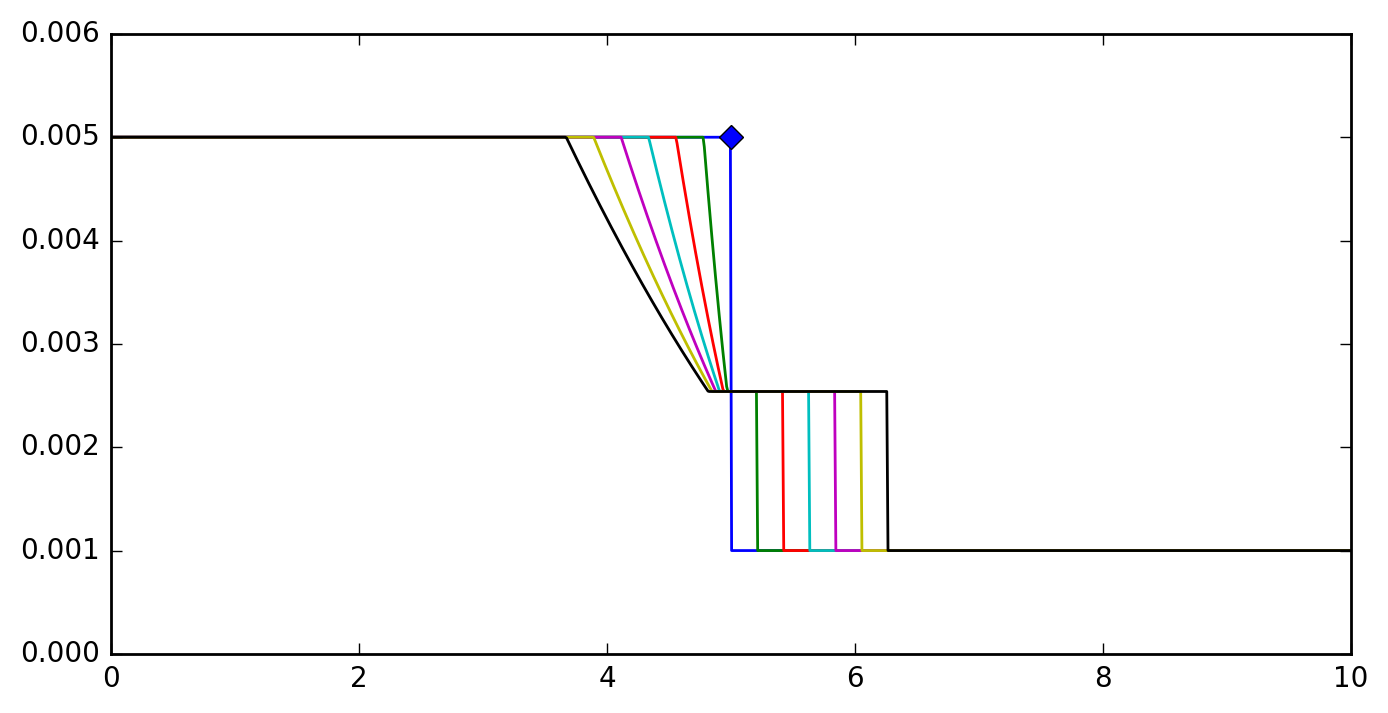

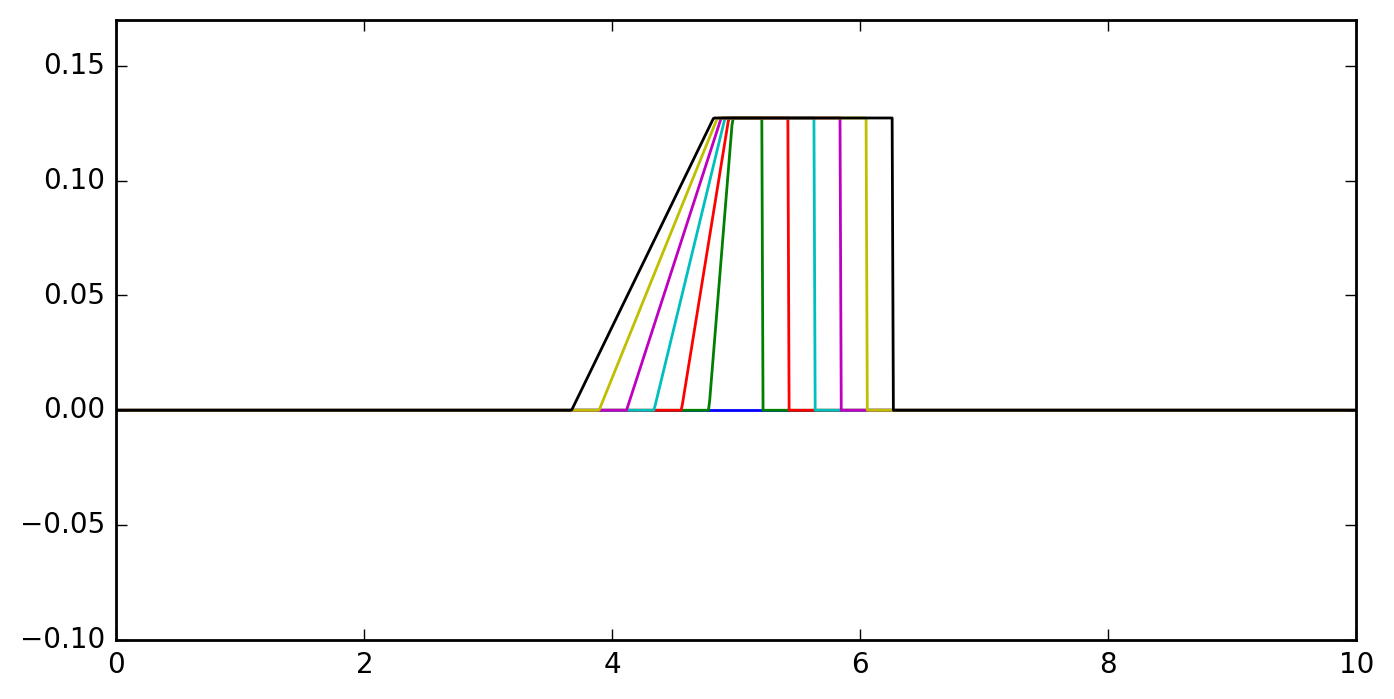

In [4]:
# Plot analytic solution
x0 = 5.0
L = 10.0
g = 9.81
hr = 0.001
hl = 0.005
T = [0,1,2,3,4,5,6]
cm = 0.1578324867 # dependent of g, hr, hl

def xA(t, x0):
    return x0 - t*np.sqrt(g*hl)
def xB(t, x0):
    return x0 + t*(2*np.sqrt(g*hl) - 3*cm)
def xC(t, x0):
    return x0 + t*(2*cm**2 *(np.sqrt(g*hl) - cm))/(cm**2 - g*hr)

def h_rarefaction(t, x0, x):
    h =(4.0/(9.0*g))* (np.sqrt(g*hl) - (x - x0)/(2*t))**2
    u = (2.0/3.0)*((x-x0)/t + np.sqrt(g*hl))
    return h, u
    
def swashes_h(t, x0, x_array):
    h = np.zeros_like(x_array)
    u = np.zeros_like(x_array)
    N = len(x_array)
    x_a = xA(t, x0)
    x_b = xB(t, x0)
    x_c = xC(t, x0)
    for i in range(N):
        x = x_array[i]
        if x < x_a:
            h[i] = hl
        elif x < x_b:
            h[i], u[i] = h_rarefaction(t, x0, x)
        elif x < x_c:
            h[i] = cm*cm/g
            u[i] = 2*(np.sqrt(g*hl)  - cm)
        else:
            h[i] = hr
    return h, u

x_array = np.linspace(0,10.0,num=1000)
x_a = xA(6.0, x0)
x_b = xB(6.0, x0)
x_c = xC(6.0, x0)
print x_a, x_b, x_c
fig = plt.figure(figsize=(8,4))
for t in range(7):
    h, u = swashes_h(t, x0, x_array)
    plt.plot(x_array, h)
plt.plot(x0, hl, 'D')
plt.ylim(0.0, 0.006)

fig = plt.figure(figsize=(8,4))
for t in range(7):
    h, u = swashes_h(t, x0,  x_array)
    plt.plot(x_array, u)
plt.ylim(-0.1, 0.17)

In [68]:
def plotDiagonalSlice(figh, figu, figShock, exact, h1, u1, v1, t, Lx, nx, x0, rk_order, dim_split):
    start_index = 50+2
    dx_diag = np.sqrt(2)*dx
    length = dx_diag*nx
    x0_index = x0/dx_diag
    x_array = np.linspace(0.0, length, num=nx)
    h = np.zeros_like(x_array)
    u = np.zeros_like(x_array)
    v = np.zeros_like(x_array)    
    
    domain_a = 30*200/nx
    domain_b = 100*200/nx
    
    # Obtain analytic solution
    if exact:
        label = "analytic"
        symbol = 'k'
        if (t == 0): 
            symbol = 'k:'
            label = "initial"
        
        hs, us = swashes_h(t, x0, x_array)
        #plt.figure(figh.number)
        plt.subplot(3,1,1)
        plt.plot(x_array[domain_a:-domain_b], hs[domain_a:-domain_b], symbol, label=label)
        #plt.plot(x0, hl, 'D')
        
        #plt.figure(figu.number)
        plt.subplot(3,1,2)
        plt.plot(x_array[domain_a:-domain_b], us[domain_a:-domain_b], symbol, label=label)
        
        #plt.figure(figShock.number)
        plt.subplot(3,1,3)
        plt.plot(x_array[int(domain_a*1.6):-int(domain_b*1.1)], hs[int(domain_a*1.6):-int(domain_b*1.1)], symbol, label=label)
 
        
        return

    
    label = "RK" + str(rk_order)
    color = 'b'
    symbol = '-'
    if (dim_split == 1):
        color = 'r'
        label = "Godunov " + label
    elif (dim_split == 2):
        label = "Strang " + label
        color = 'g'
    if (rk_order == 2):
        symbol = ':'
    elif (rk_order == 3):
        symbol = '-.'
    
    # Read from simulation data
    for i in range(nx):
        ig = i + 2
        h[i] = h1[ig, ig]
        u[i] = (np.sqrt(u1[ig,ig]**2 + v1[ig,ig]**2))/h[i]
        v[i] = v1[ig,ig]/h[i]    

    
    #plt.figure(figh.number)
    plt.subplot(3,1,1)
    plt.plot(x_array[domain_a:-domain_b], h[domain_a:-domain_b], color+symbol, label=label)
    
    plt.subplot(3,1,2)
    plt.plot(x_array[domain_a:-domain_b], u[domain_a:-domain_b], color+symbol, label=label)

    plt.subplot(3,1,3)
    plt.plot(x_array[int(domain_a*1.8):-int(domain_b*1.1)], h[int(domain_a*1.8):-int(domain_b*1.1)], color+symbol, label=label)

    

10.0
dx,dy: 0.05 0.05
max_dt 0.0336498803689
(rk_order, dim_split) (1, 0)
100% => t=6.00004	Max h: 0.005	Max u: 0.000232402	Max v: 0.000232402
(rk_order, dim_split) (2, 0)
100% => t=6.00004	Max h: 0.005	Max u: 0.000230936	Max v: 0.000230936
(rk_order, dim_split) (3, 0)
100% => t=6.00004	Max h: 0.005	Max u: 0.000230922	Max v: 0.000230922
(rk_order, dim_split) (1, 1)
100% => t=6.00004	Max h: 0.005	Max u: 0.000232062	Max v: 0.000231995
(rk_order, dim_split) (2, 1)
100% => t=6.00004	Max h: 0.005	Max u: 0.000230926	Max v: 0.000230843
(rk_order, dim_split) (3, 1)
100% => t=6.00004	Max h: 0.005	Max u: 0.000230922	Max v: 0.000230839
(rk_order, dim_split) (1, 2)
100% => t=6.00004	Max h: 0.005	Max u: 0.000231686	Max v: 0.000231889
(rk_order, dim_split) (2, 2)
100% => t=6.00004	Max h: 0.005	Max u: 0.000230922	Max v: 0.000230927
(rk_order, dim_split) (3, 2)
100% => t=6.00004	Max h: 0.005	Max u: 0.000230928	Max v: 0.000230928


(4.7, 5.3)

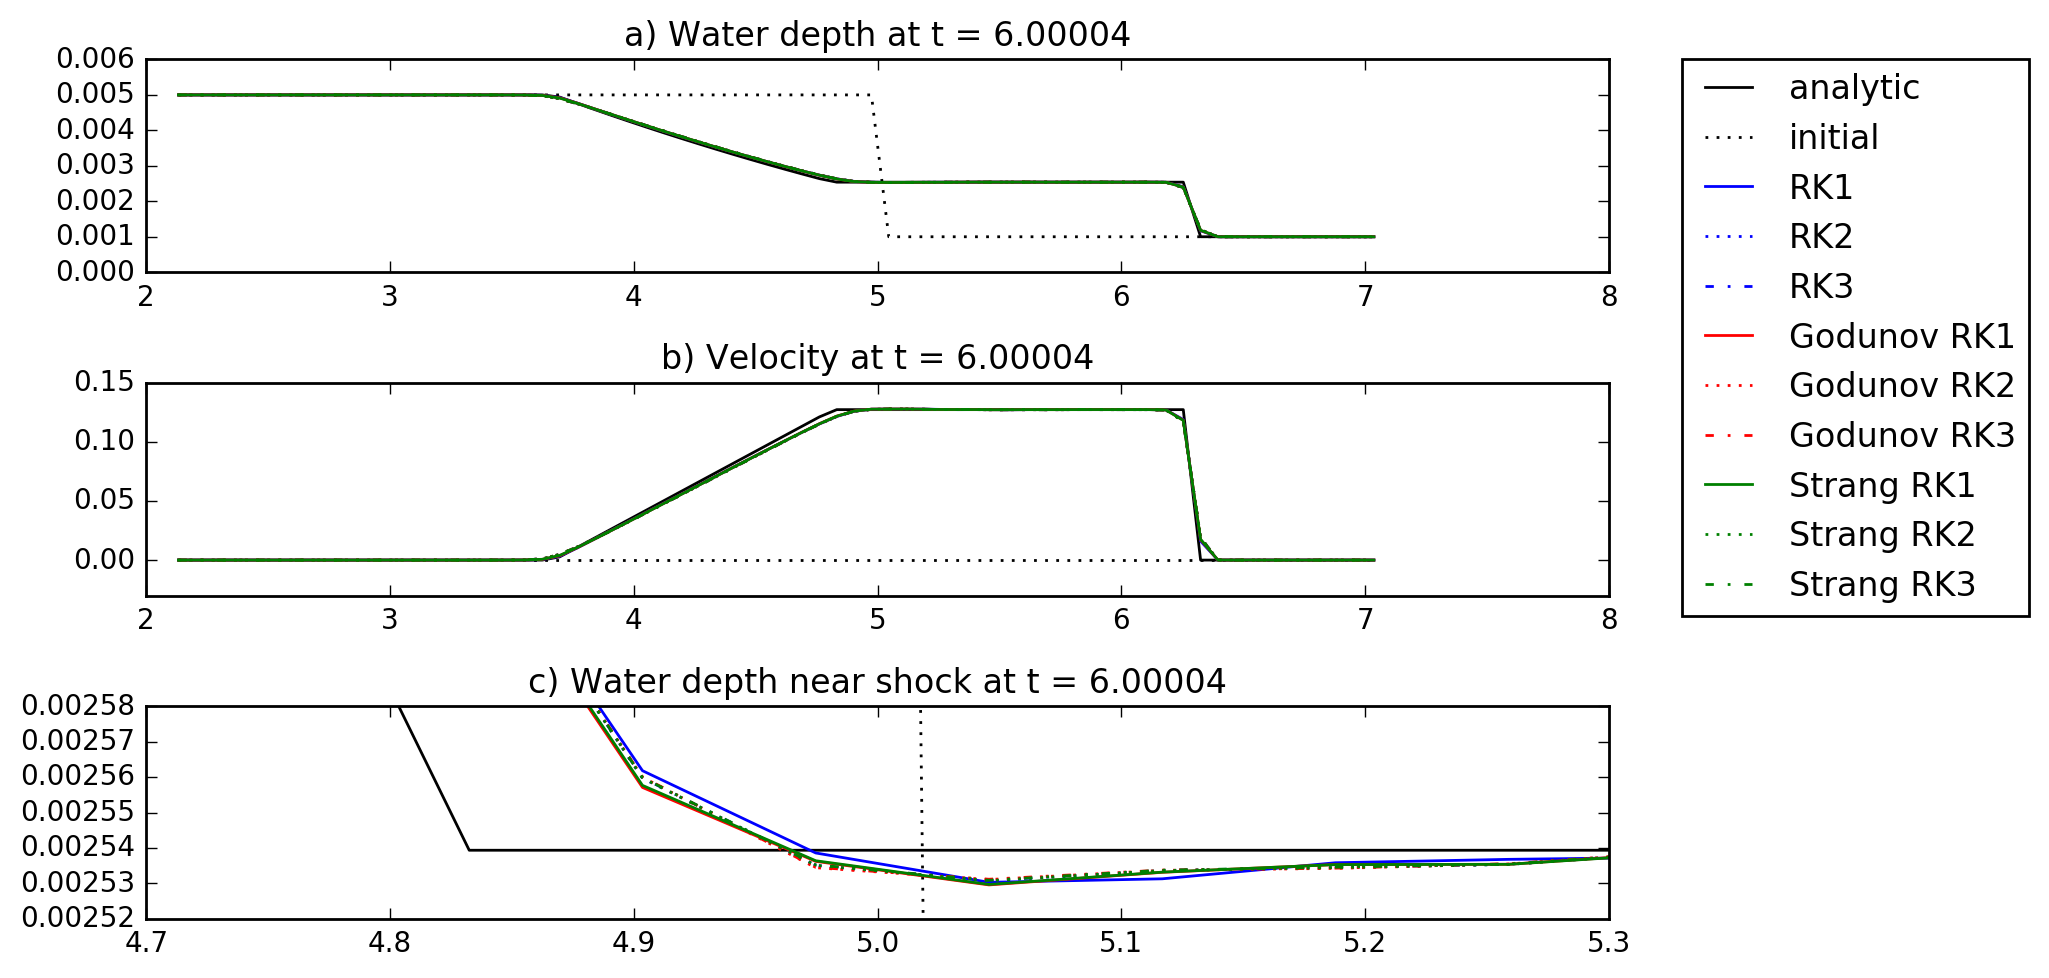

In [69]:
#Clean up old simulator if any:
if 'sim' in globals():
    sim.cleanUp()
    

# Using SWASHES parameters:
x0 = 5.0
L = 10.0
g = 9.81
hr = 0.001
hl = 0.005
cm = 0.1578324867  # dependent of g, hr, hl

# Hypothenus = L - xBuffer
Lx = L
print Lx

    
nx = 200
ny = 200

dx = Lx/nx
dy = Lx/ny
print "dx,dy:", dx, dy

theoretically_max_u = 0.15
max_dt = 0.25* dx/(theoretically_max_u + np.sqrt(g*hl))
print "max_dt", max_dt
dt = 0.01
T = 6.0

# Missing parameters:
f = 0.0
r = 0.0

boundaryConditions = Common.BoundaryConditions()
ghosts = np.array([2,2,2,2]) # north, east, south, west
validDomain = np.array([2,2,2,2])
    
dataShape = (ny + ghosts[0]+ghosts[2], 
             nx + ghosts[1]+ghosts[3])

h0SWASHES = np.zeros(dataShape, dtype=np.float32, order='C');
u0 = np.zeros(dataShape, dtype=np.float32, order='C');
v0 = np.zeros(dataShape, dtype=np.float32, order='C');

# Bathymetry:
Bi = np.zeros((dataShape[0]+1, dataShape[1]+1), dtype=np.float32, order='C')


makeDiagonalSwashes(h0SWASHES, nx, ny, dx, dy, ghosts, x0, hl, hr)
#make1DSwashes(h0, nx, ny, dx, dy, ghosts, x0, hl, hr)

timeString = " at t = " + str(t)
fig = plt.figure(figsize=(8,5))
figh = plt.subplot(3,1,1)
plt.title("a) Water depth"+timeString)
figu = plt.subplot(3,1,2)
plt.title("b) Velocity"+timeString)
figShock = plt.subplot(3,1,3)
plt.title("c) Water depth near shock"+timeString)
plt.tight_layout()


#figh = plt.figure(figsize=(8,3))
#figu = plt.figure(figsize=(8,3))
#figShock = plt.figure(figsize=(8,3))
plotDiagonalSlice(figh, figu, figShock, True, None, None, None, t, Lx, nx, x0, None, None )
plotDiagonalSlice(figh, figu, figShock, True, None, None, None, 0.0, Lx, nx, x0, None, None )
 

#Initialize simulator
reload(CDKLM16)
reload(KP07)
for dim_split in range(3):
    for rk_order in range(1,4):

        sim = CDKLM16.CDKLM16(cl_ctx, \
                        h0SWASHES, u0, v0, Bi, \
        #sim = KP07.KP07(cl_ctx, \
        #                h0, Bi, u0, v0, \
                        nx, ny, \
                        dx, dy, dt, \
                        g, f, r, \
                        boundary_conditions=boundaryConditions, \
                        reportGeostrophicEquilibrium=False, \
                        rk_order=rk_order, dim_split=dim_split)


        t = sim.step(T)
        h1, u1, v1 = sim.download()
        print "(rk_order, dim_split)", (rk_order, dim_split)
        print "100% => t=" + str(t) + "\tMax h: " + str(np.max(h1)) + \
              "\tMax u: " + str(np.max(u1)) + \
              "\tMax v: " + str(np.max(v1))
        sim.cleanUp()
        
        plotDiagonalSlice(figh, figu, figShock, False, h1, u1, v1, t, Lx, nx, x0, rk_order, dim_split )

h1FlatBottom = h1
        
plt.subplot(3,1,1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.subplot(3,1,1)
plt.ylim(0.0, 0.006)

plt.subplot(3,1,2)
plt.ylim(-0.03, 0.15)

plt.subplot(3,1,3)
#plt.ylim(0.00235, 0.00260)
#plt.xlim(4.7, 6.5)
plt.ylim(0.00252, 0.00258)
plt.xlim(4.7, 5.3)


In order to validate all time integration methods, we consider a dam break on a flat topography without Coriolis, for which an analytic solution exists.
Since dimensional splitting needs to be validated on a 2D domain, the initial dam is placed along the line $y = \sqrt{2}x_0 -x$, and we investigate the solution along the line $y = x$.
As can be seen in Figure \reffig{swashes}, all methods generate the same results, and accurately capture the shock and refraction wave.




## Bottom topography
The bottom topography source terms are ment to balance out the gravity terms that appears in the fluxes.
It is therefore easy to see that they belong the $x$-derivative belongs to the $x$-flux, and $y$-derivative to the $y$-flux, resulting in the following splitting
$$split_x$$
$$split_y$$

In [70]:
def plotDiagonalSliceBottom(figh, figu, figShock, bottom, h1, u1, v1, Bm, t, Lx, nx, x0, rk_order, dim_split):
    dx_diag = np.sqrt(2)*dx
    length = dx_diag*nx
    x0_index = x0/dx_diag
    x_array = np.linspace(0.0, length, num=nx)
    h = np.zeros_like(x_array)
    u = np.zeros_like(x_array)
    v = np.zeros_like(x_array)    
    b = np.zeros_like(x_array)    
    
    domain_a = 30*200/nx
    domain_b = 100*200/nx
        
       
    label = "RK" + str(rk_order)
    color = 'b'
    symbol = '-'
    if (dim_split == 1):
        color = 'r'
        label = "Godunov " + label
    elif (dim_split == 2):
        label = "Strang " + label
        color = 'g'
    if (rk_order == 2):
        symbol = ':'
    elif (rk_order == 3):
        symbol = '-.'
    
    # Read from simulation data
    for i in range(nx):
        ig = i + 2
        b[i] = Bm[ig, ig]
        if not bottom:
            h[i] = h1[ig, ig]
            u[i] = (np.sqrt(u1[ig,ig]**2 + v1[ig,ig]**2))/(h[i]-b[i])
            v[i] = v1[ig,ig]/h[i]    

    
    # Obtain analytic solution
    if bottom:
        label = "Bottom"
        symbol = 'k'
       
        print x_array[domain_a:-domain_b].shape, b[domain_a:-domain_b].shape
        #plt.figure(figh.number)
        plt.subplot(3,1,1)
        plt.plot(x_array[domain_a:-domain_b], b[domain_a:-domain_b], symbol, label=label)

        #plt.figure(figShock.number)
        plt.subplot(3,1,3)
        plt.plot(x_array[int(domain_a):-int(domain_b)], b[int(domain_a):-int(domain_b)], symbol, label=label)
        return
    
    #plt.figure(figh.number)
    plt.subplot(3,1,1)
    plt.plot(x_array[domain_a:-domain_b], h[domain_a:-domain_b], color+symbol, label=label)
    
    plt.subplot(3,1,2)
    plt.plot(x_array[domain_a:-domain_b], u[domain_a:-domain_b], color+symbol, label=label)

    plt.subplot(3,1,3)
    plt.plot(x_array[int(domain_a):-int(domain_b)], h[int(domain_a):-int(domain_b)], color+symbol, label=label)

    

10.0
dx,dy: 0.05 0.05
max_dt 0.0218070472407
(70,) (70,)
(rk_order, dim_split) (1, 0)
100% => t=6.00004	Max h: 0.01	Max u: 0.000615346	Max v: 0.000615346
(rk_order, dim_split) (2, 0)
100% => t=6.00004	Max h: 0.01	Max u: 0.000614547	Max v: 0.000614546
(rk_order, dim_split) (3, 0)
100% => t=6.00004	Max h: 0.01	Max u: 0.000614564	Max v: 0.000614564
(rk_order, dim_split) (1, 1)
100% => t=6.00004	Max h: 0.01	Max u: 0.000614739	Max v: 0.000614713
(rk_order, dim_split) (2, 1)
100% => t=6.00004	Max h: 0.01	Max u: 0.000614564	Max v: 0.000614544
(rk_order, dim_split) (3, 1)
100% => t=6.00004	Max h: 0.01	Max u: 0.000614577	Max v: 0.000614551
(rk_order, dim_split) (1, 2)
100% => t=6.00004	Max h: 0.01	Max u: 0.000614564	Max v: 0.000614831
(rk_order, dim_split) (2, 2)
100% => t=6.00004	Max h: 0.01	Max u: 0.00061456	Max v: 0.000614553
(rk_order, dim_split) (3, 2)
100% => t=6.00004	Max h: 0.01	Max u: 0.000614583	Max v: 0.000614581


(2.8, 3.5)

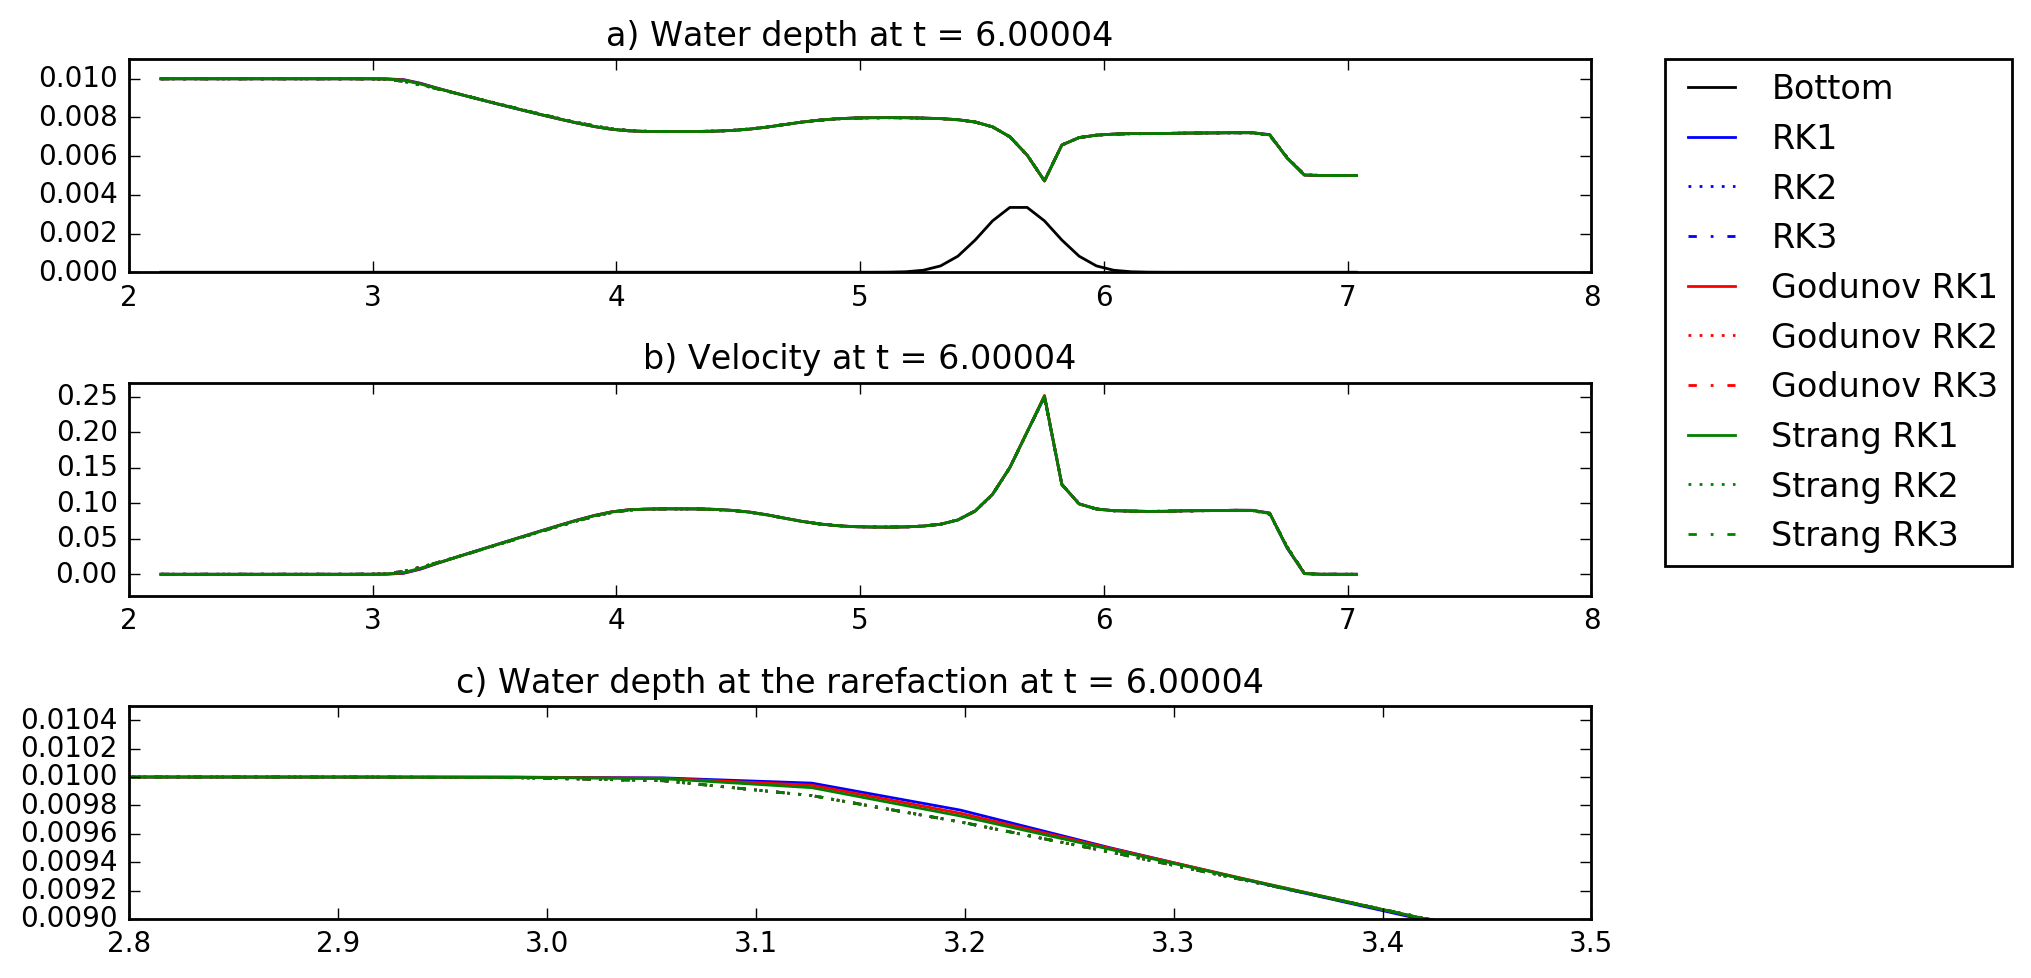

In [72]:
#Clean up old simulator if any:
if 'sim' in globals():
    sim.cleanUp()
    
boundaryConditions = Common.BoundaryConditions()
ghosts = np.array([2,2,2,2]) # north, east, south, west
validDomain = np.array([2,2,2,2])
    
dataShape = (ny + ghosts[0]+ghosts[2], 
             nx + ghosts[1]+ghosts[3])


# Using SWASHES parameters:
x0 = 5.0
L = 10.0
g = 9.81
hr = 0.005
hl = 0.010
cm = 0.1578324867



# Hypothenus = L - xBuffer
Lx = L
print Lx
    
nx = 200
ny = 200

dx = Lx/nx
dy = Lx/ny
print "dx,dy:", dx, dy

theoretically_max_u = 0.26
max_dt = 0.25* dx/(theoretically_max_u + np.sqrt(g*hl))
print "max_dt", max_dt
dt = 0.01
T = 6.0

# Missing parameters:
f = 0.0
r = 0.0

h0 = np.zeros(dataShape, dtype=np.float32, order='C');
u0 = np.zeros(dataShape, dtype=np.float32, order='C');
v0 = np.zeros(dataShape, dtype=np.float32, order='C');

# Bathymetry:
Bi = np.zeros((dataShape[0]+1, dataShape[1]+1), dtype=np.float32, order='C')
def diagonalWallBathymetryNoHole(B, nx, ny, dx, dy, halo, height):
    for j in range(0, ny+1):
        for i in range(0, nx+1):
            factor = 1.0
            B[j+halo[2], i+halo[3]] = factor*height*np.exp(-0.03*(abs(160-j - i)**2))
diagonalWallBathymetryNoHole(Bi, nx, ny, dx, dy, ghosts, 0.0035)

makeDiagonalSwashes(h0, nx, ny, dx, dy, ghosts, x0, hl, hr)
#make1DSwashes(h0, nx, ny, dx, dy, ghosts, x0, hl, hr)

timeString = " at t = " + str(t)
fig = plt.figure(figsize=(8,5))
figh = plt.subplot(3,1,1)
plt.title("a) Water depth"+timeString)
figu = plt.subplot(3,1,2)
plt.title("b) Velocity"+timeString)
figShock = plt.subplot(3,1,3)
plt.title("c) Water depth at the rarefaction"+timeString)
plt.tight_layout()



#Initialize simulator
reload(CDKLM16)
reload(KP07)
for dim_split in range(3):
    for rk_order in range(1,4):
  
        sim = CDKLM16.CDKLM16(cl_ctx, \
                        h0, u0, v0, Bi, \
        #sim = KP07.KP07(cl_ctx, \
        #                h0, Bi, u0, v0, \
                        nx, ny, \
                        dx, dy, dt, \
                        g, f, r, \
                        boundary_conditions=boundaryConditions, \
                        rk_order=rk_order, dim_split=dim_split)

        simBi, simBm = sim.downloadBathymetry()
        if dim_split == 0 and rk_order ==1:
            plotDiagonalSliceBottom(figh, figu, figShock, True, None, None, None, simBm, t, Lx, nx, x0, rk_order, dim_split )
            
        t = sim.step(T)
        h1, u1, v1 = sim.download()
        print "(rk_order, dim_split)", (rk_order, dim_split)
        print "100% => t=" + str(t) + "\tMax h: " + str(np.max(h1)) + \
              "\tMax u: " + str(np.max(u1)) + \
              "\tMax v: " + str(np.max(v1))
        sim.cleanUp()
        
        plotDiagonalSliceBottom(figh, figu, figShock, False, h1, u1, v1, simBm, t, Lx, nx, x0, rk_order, dim_split )

plt.subplot(3,1,1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.subplot(3,1,1)
plt.ylim(0.0, 0.011)

plt.subplot(3,1,2)
plt.ylim(-0.03, 0.27)

plt.subplot(3,1,3)
#plt.ylim(0.0045, 0.008)
#plt.xlim(5.5, 6.0)
plt.ylim(0.009, 0.0105)
plt.xlim(2.8, 3.5)



All methods are able to capture the same solution.

(0.0, 10.0)


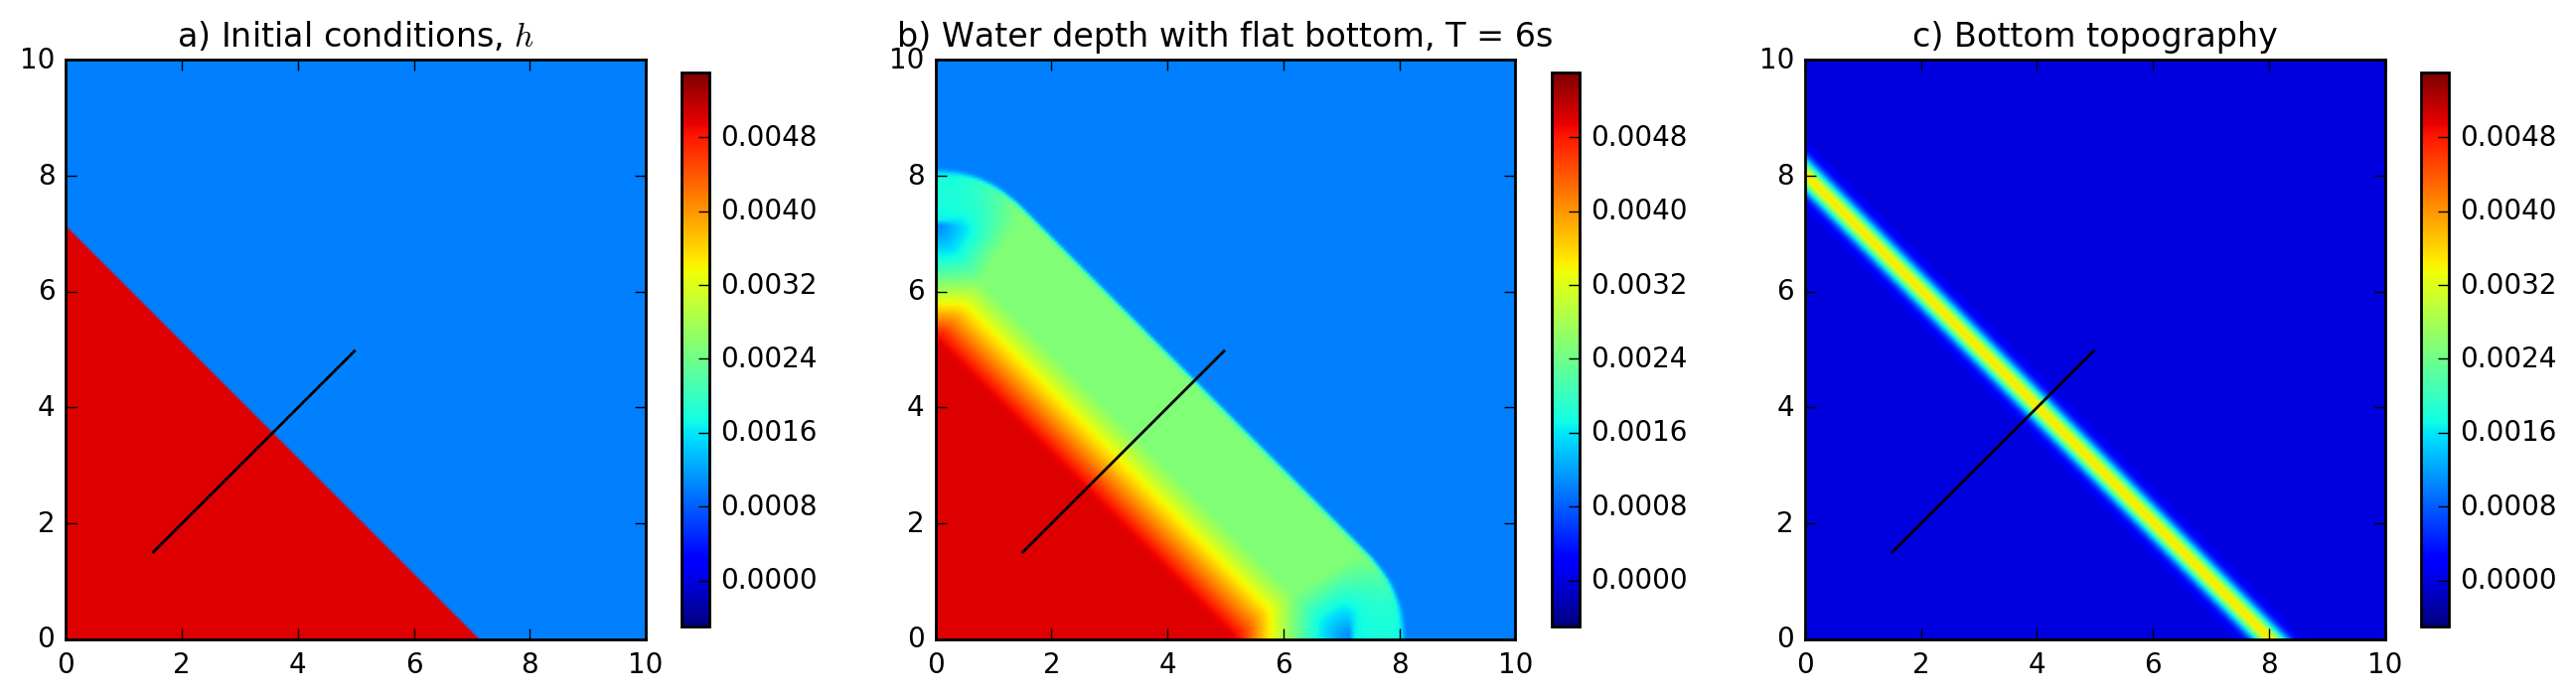

In [81]:
# Plotting initial conditions, and solution
dx_diag = np.sqrt(2)*dx
#length = dx_diag*nx
length = dx*nx
x0_index = x0/dx_diag
x_array = np.linspace(0.0, length, num=nx)
domain_a = 30*200/nx
domain_b = 100*200/nx
x_array[domain_a:-domain_b]
print (min(x_array), max(x_array))

def diagImshow(ax, data):
    ax.plot(x_array[domain_a:-domain_b],x_array[domain_a:-domain_b], color='black')
    im = ax.imshow(np.rot90(data[2:-2, 2:-2]), extent=[0, dx*nx, 0.0, dy*ny], vmin=-0.0005, vmax=0.0055)
    fig.colorbar(im, ax=ax, shrink=0.3)


OneDDiagFig, (ax1, ax2, ax3) = plt.subplots(ncols=3)

ax1.set(title='a) Initial conditions, $h$')
diagImshow(ax1, h0SWASHES)

ax2.set(title='b) Water depth with flat bottom, T = 6s')
diagImshow(ax2, h1FlatBottom)

ax3.set(title='c) Bottom topography')
diagImshow(ax3, Bi)
plt.show()


## Rossby adjustment

Wave tracking first, then steady state.

dt:  0.03125
Starting (dim_split, rk_order) (0, 1)
Total amount of execive water:  31.4697
Starting (dim_split, rk_order) (0, 2)
Total amount of execive water:  32.1594
Starting (dim_split, rk_order) (0, 3)
Total amount of execive water:  -2.21339
Starting (dim_split, rk_order) (1, 1)
Total amount of execive water:  25.9202
Starting (dim_split, rk_order) (1, 2)
Total amount of execive water:  27.1588
Starting (dim_split, rk_order) (1, 3)
Total amount of execive water:  12.5754
Starting (dim_split, rk_order) (2, 1)
Total amount of execive water:  16.2813
Starting (dim_split, rk_order) (2, 2)
Total amount of execive water:  13.8385
Starting (dim_split, rk_order) (2, 3)
Total amount of execive water:  4.20297


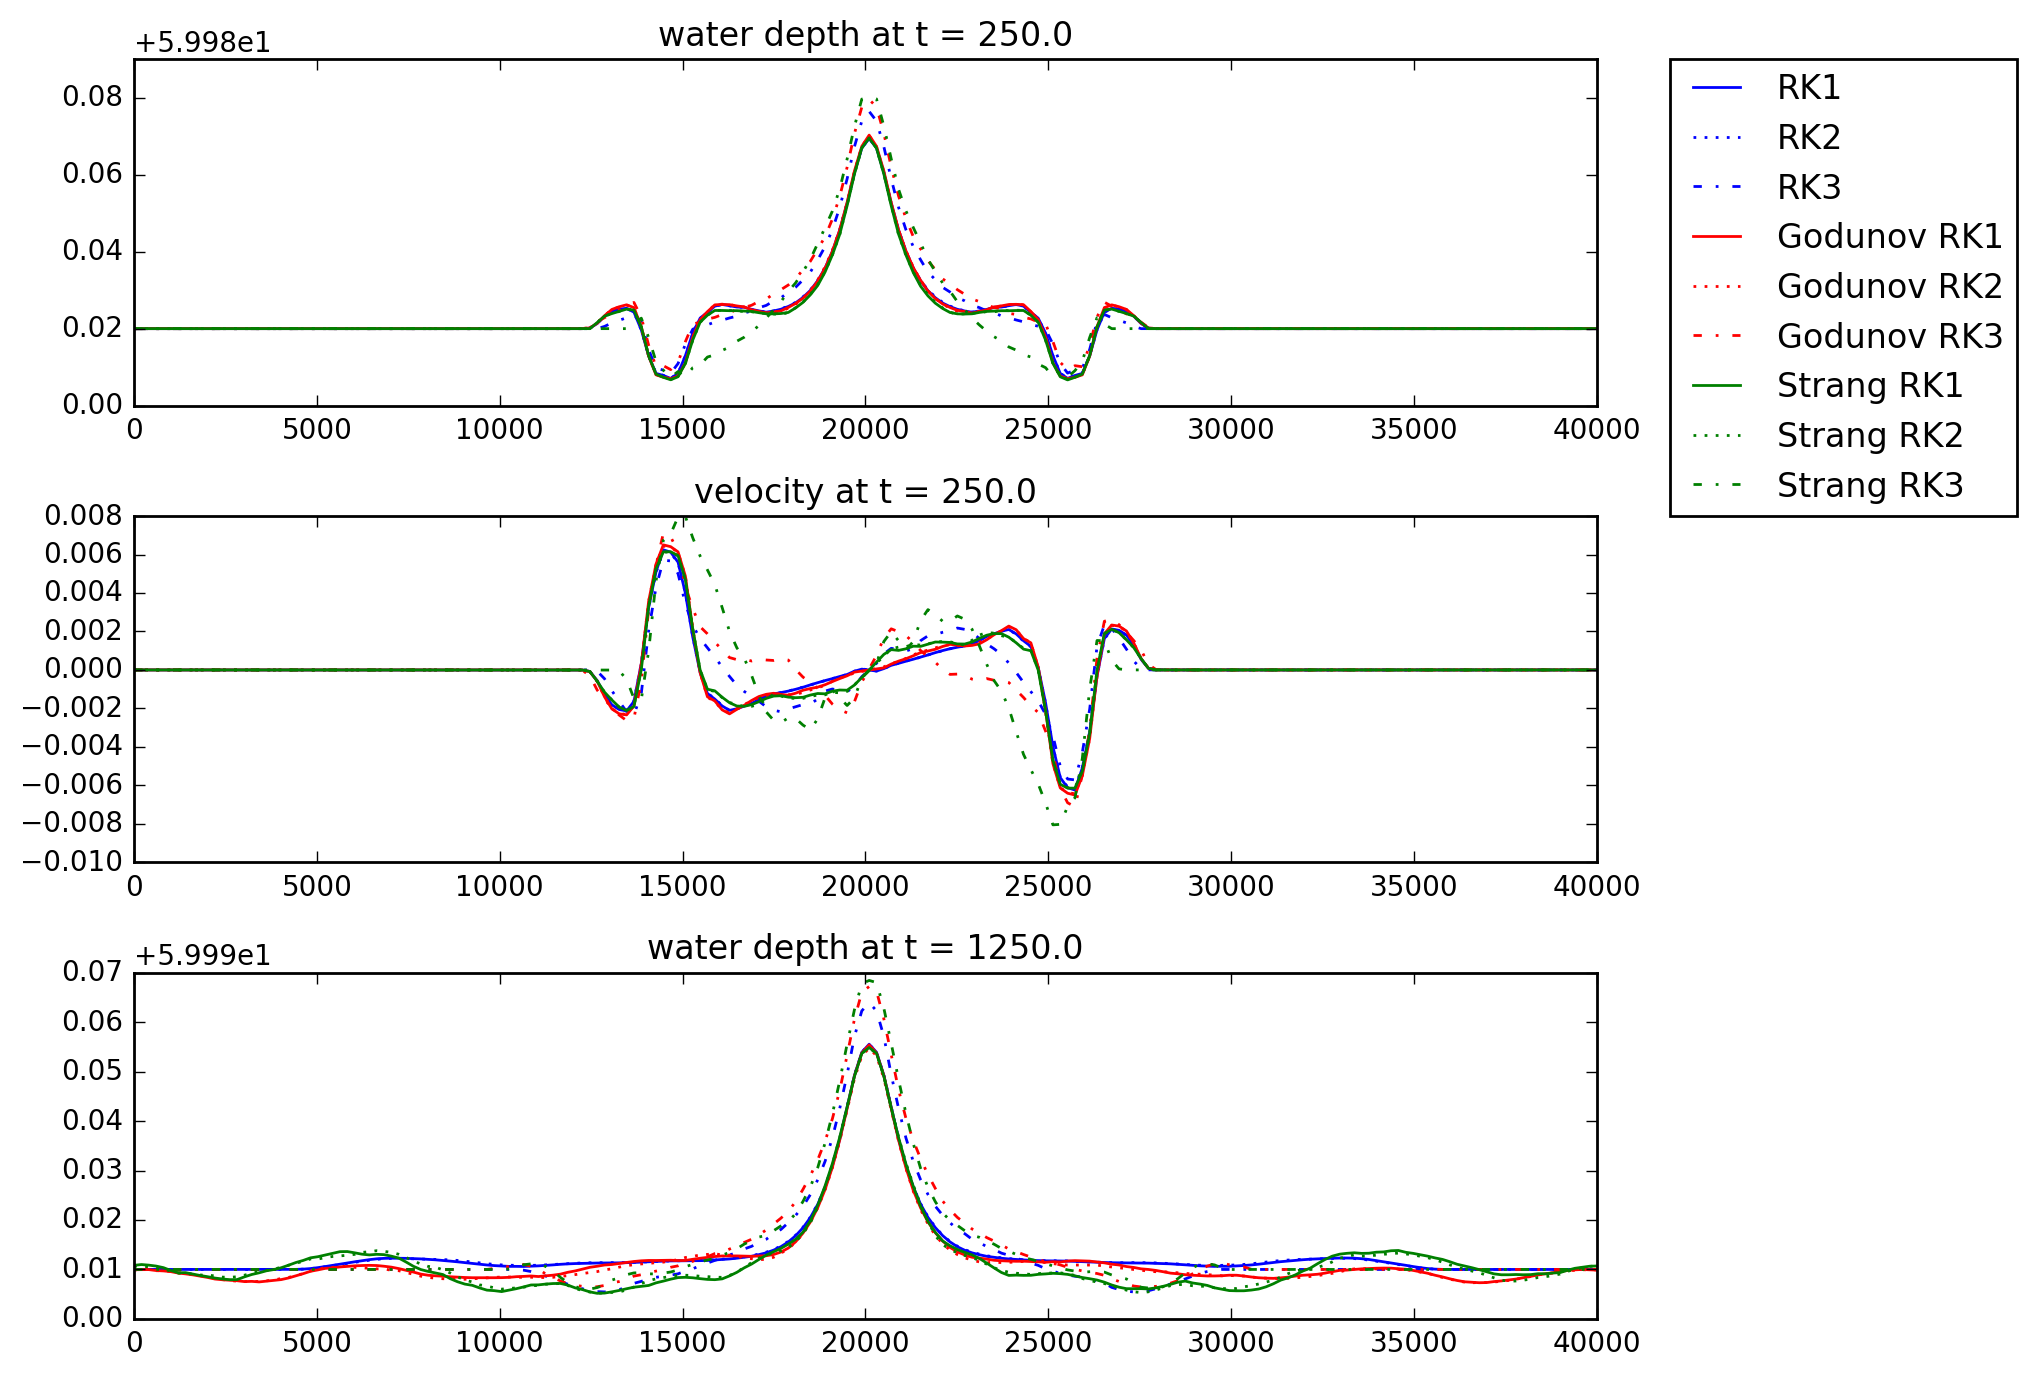

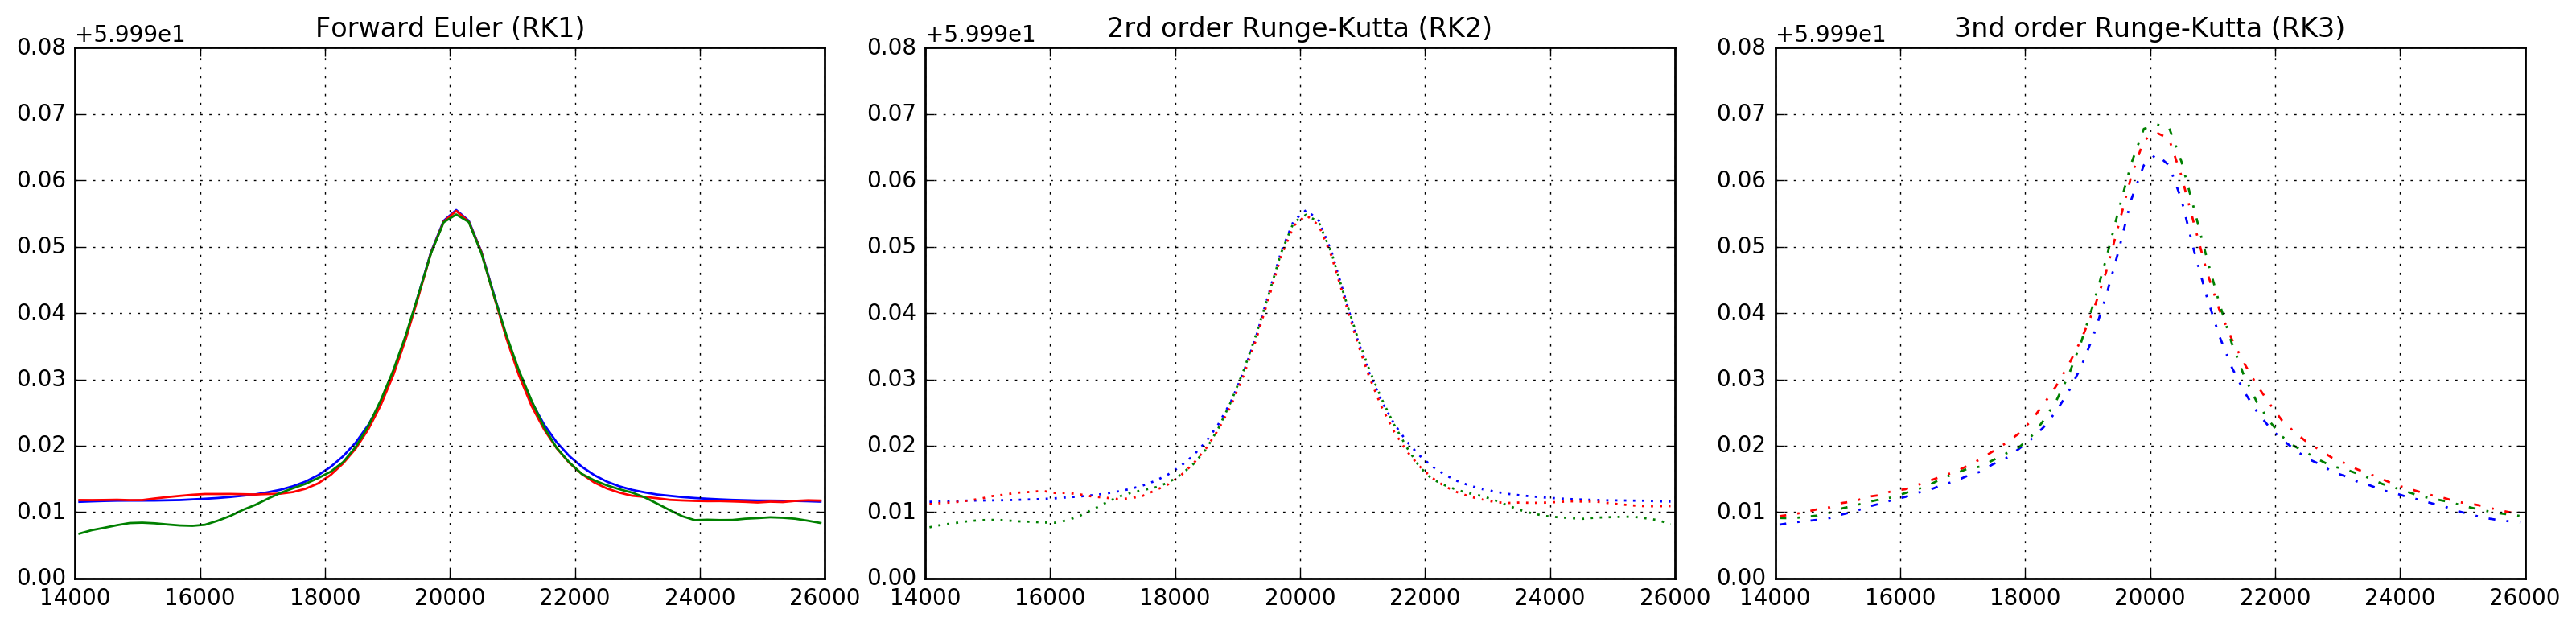

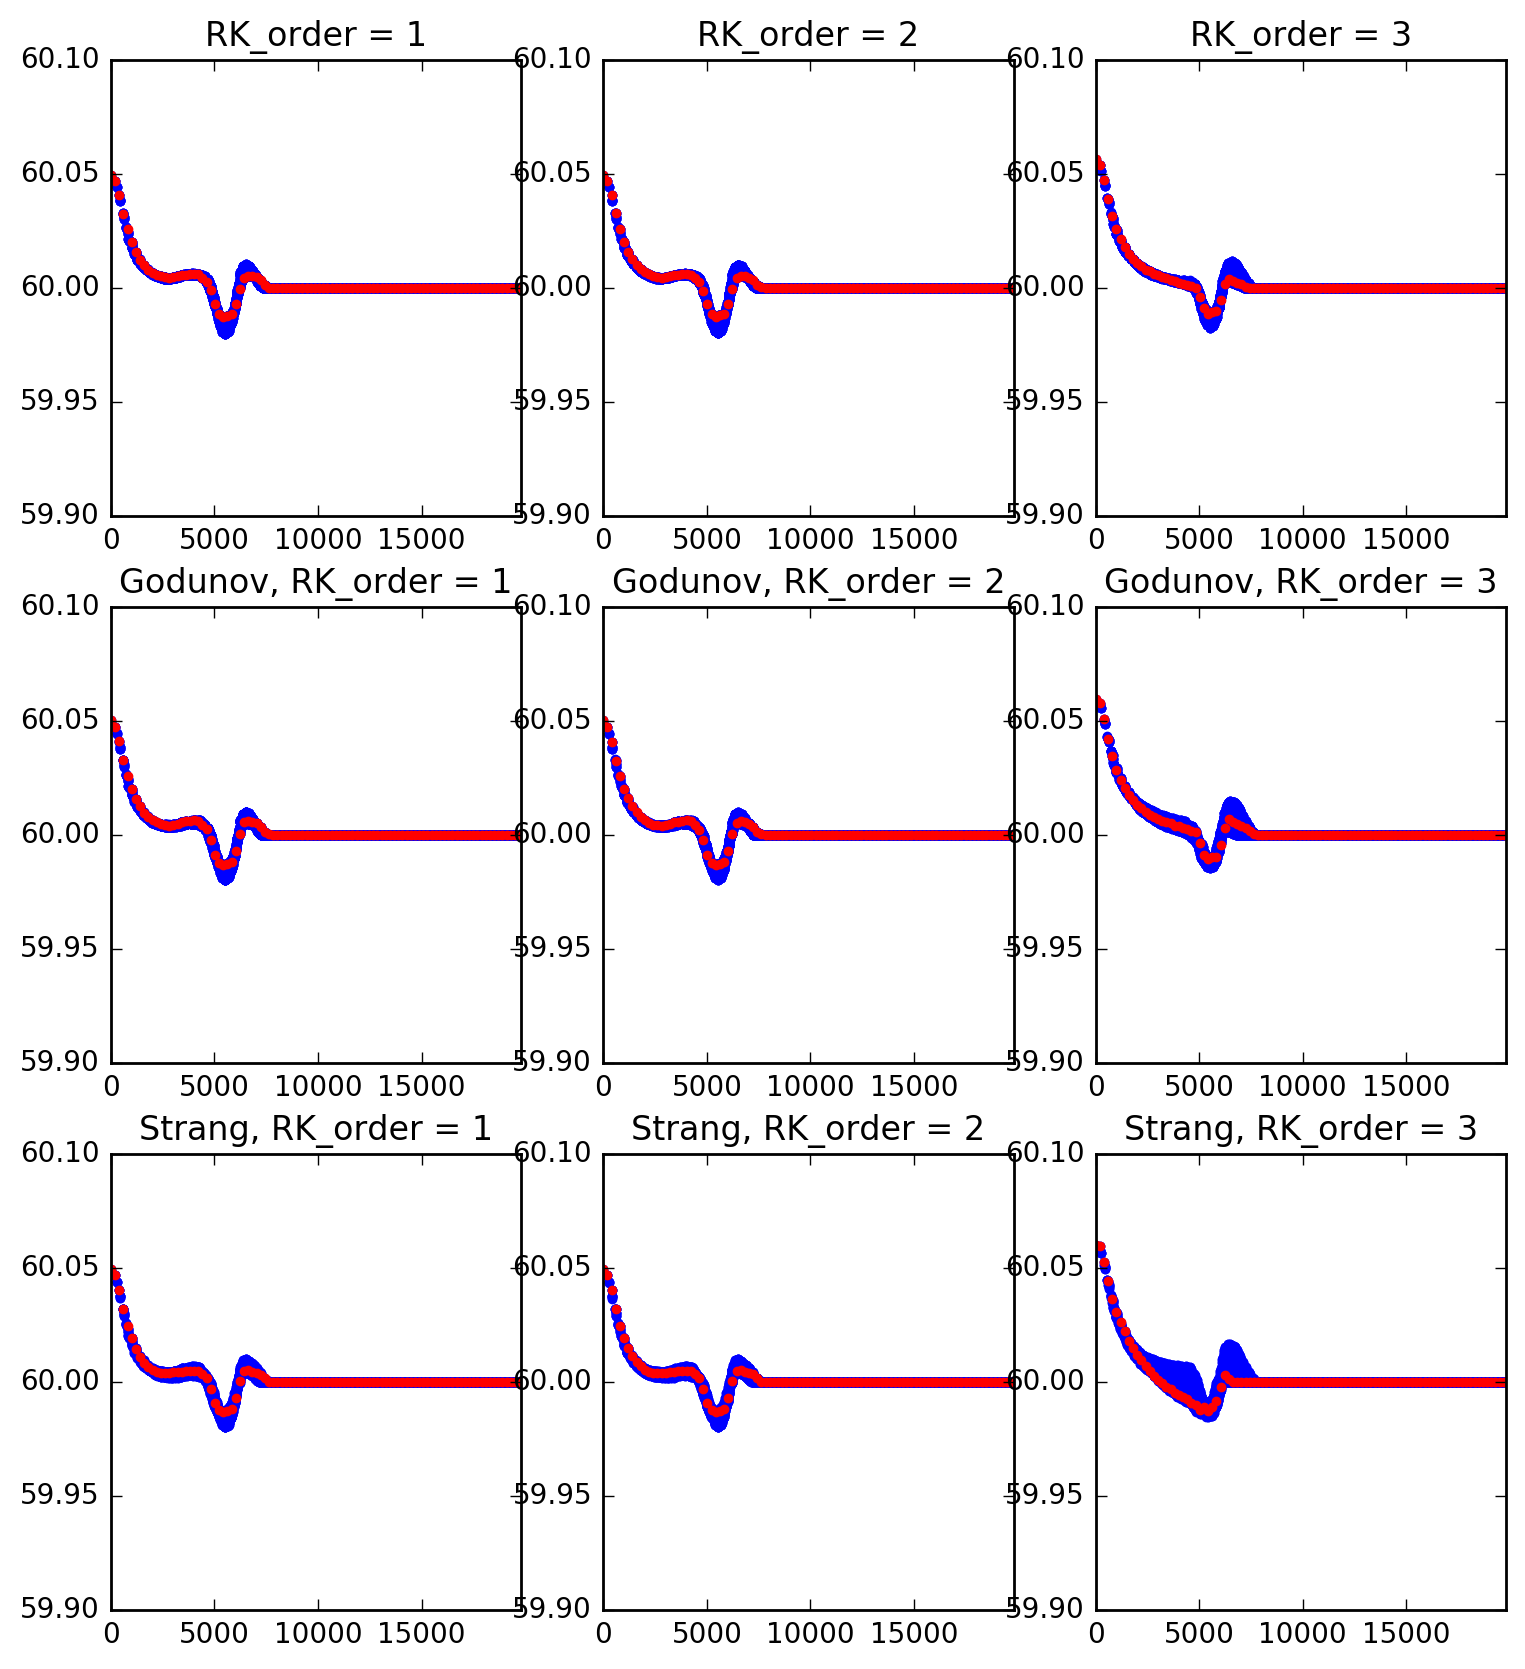

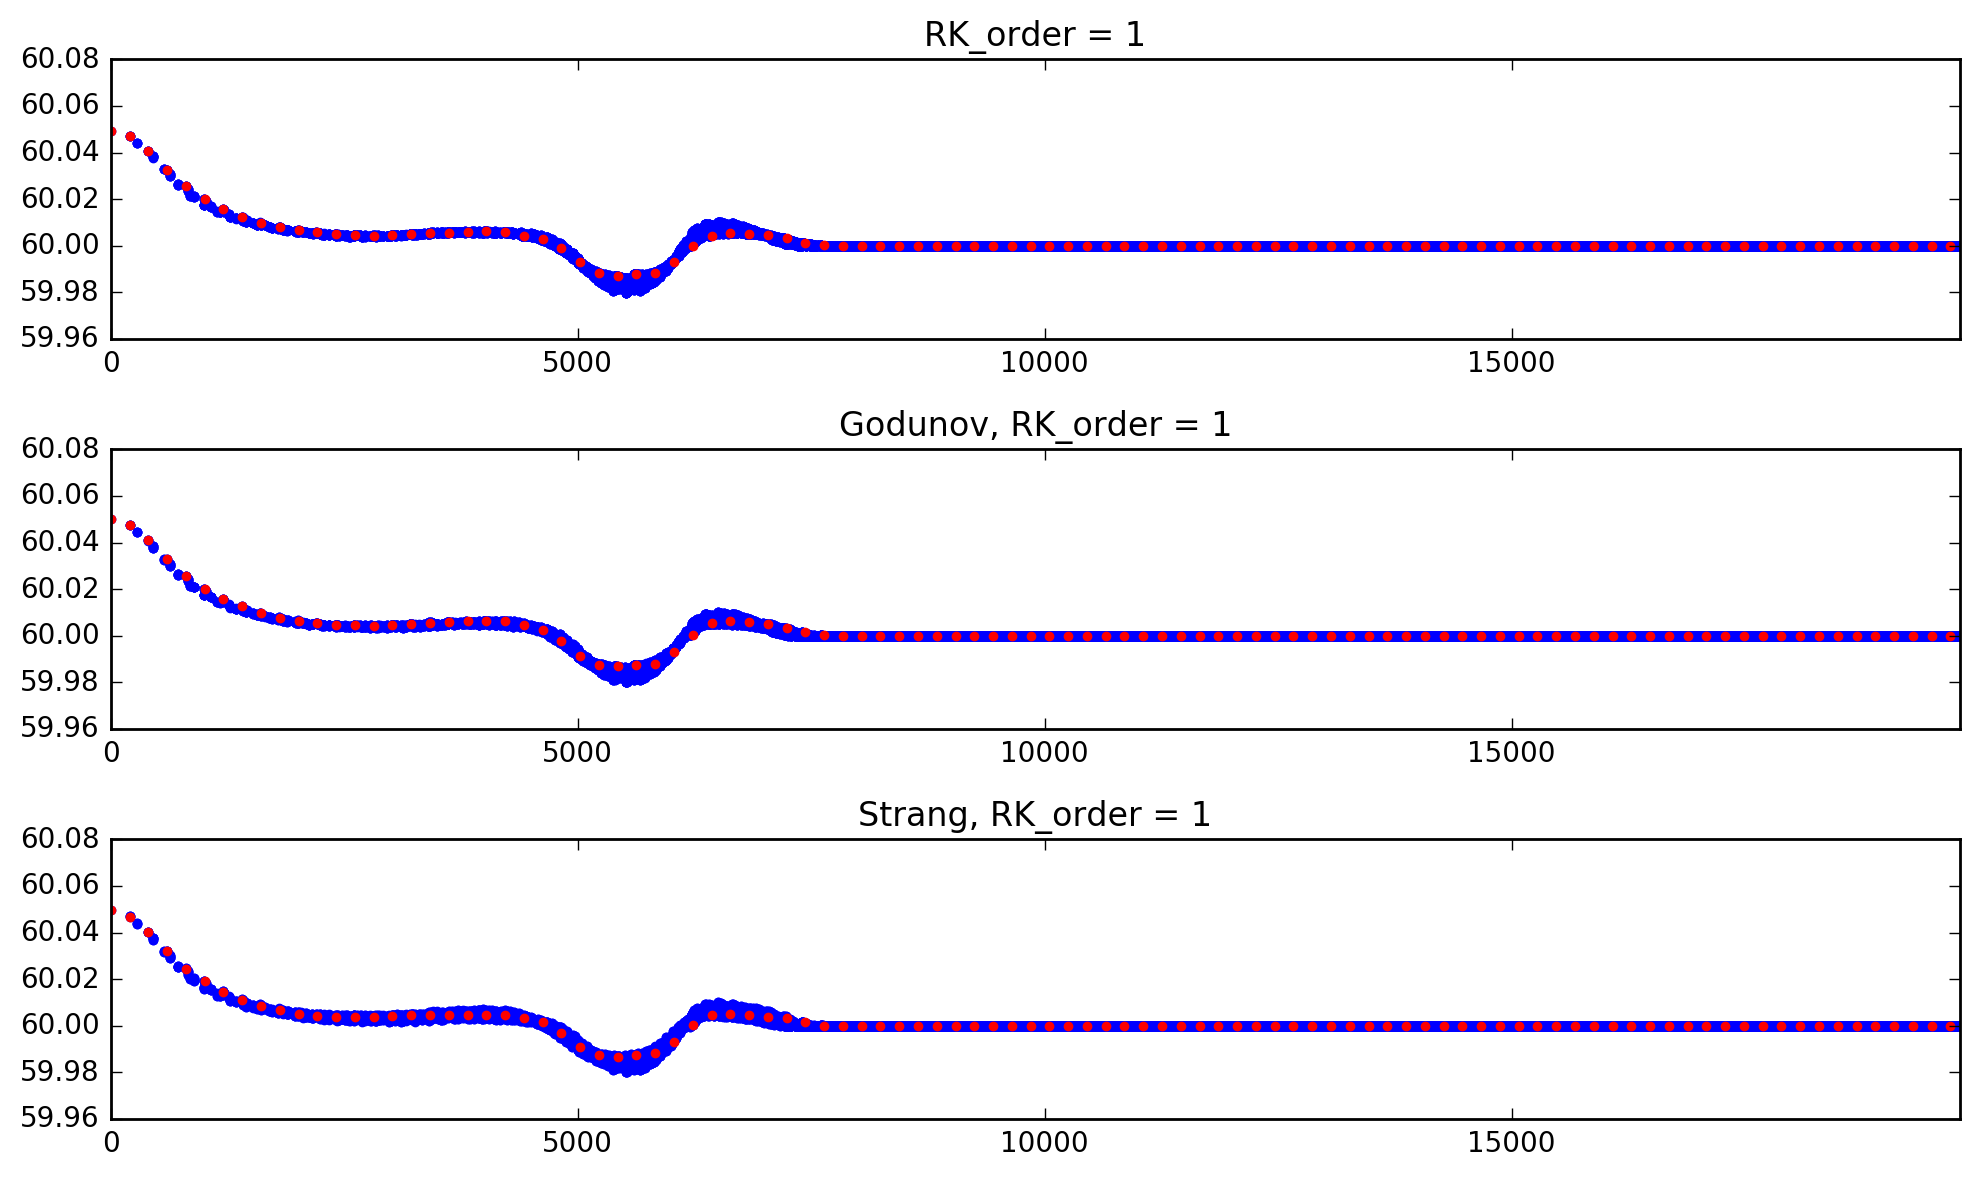

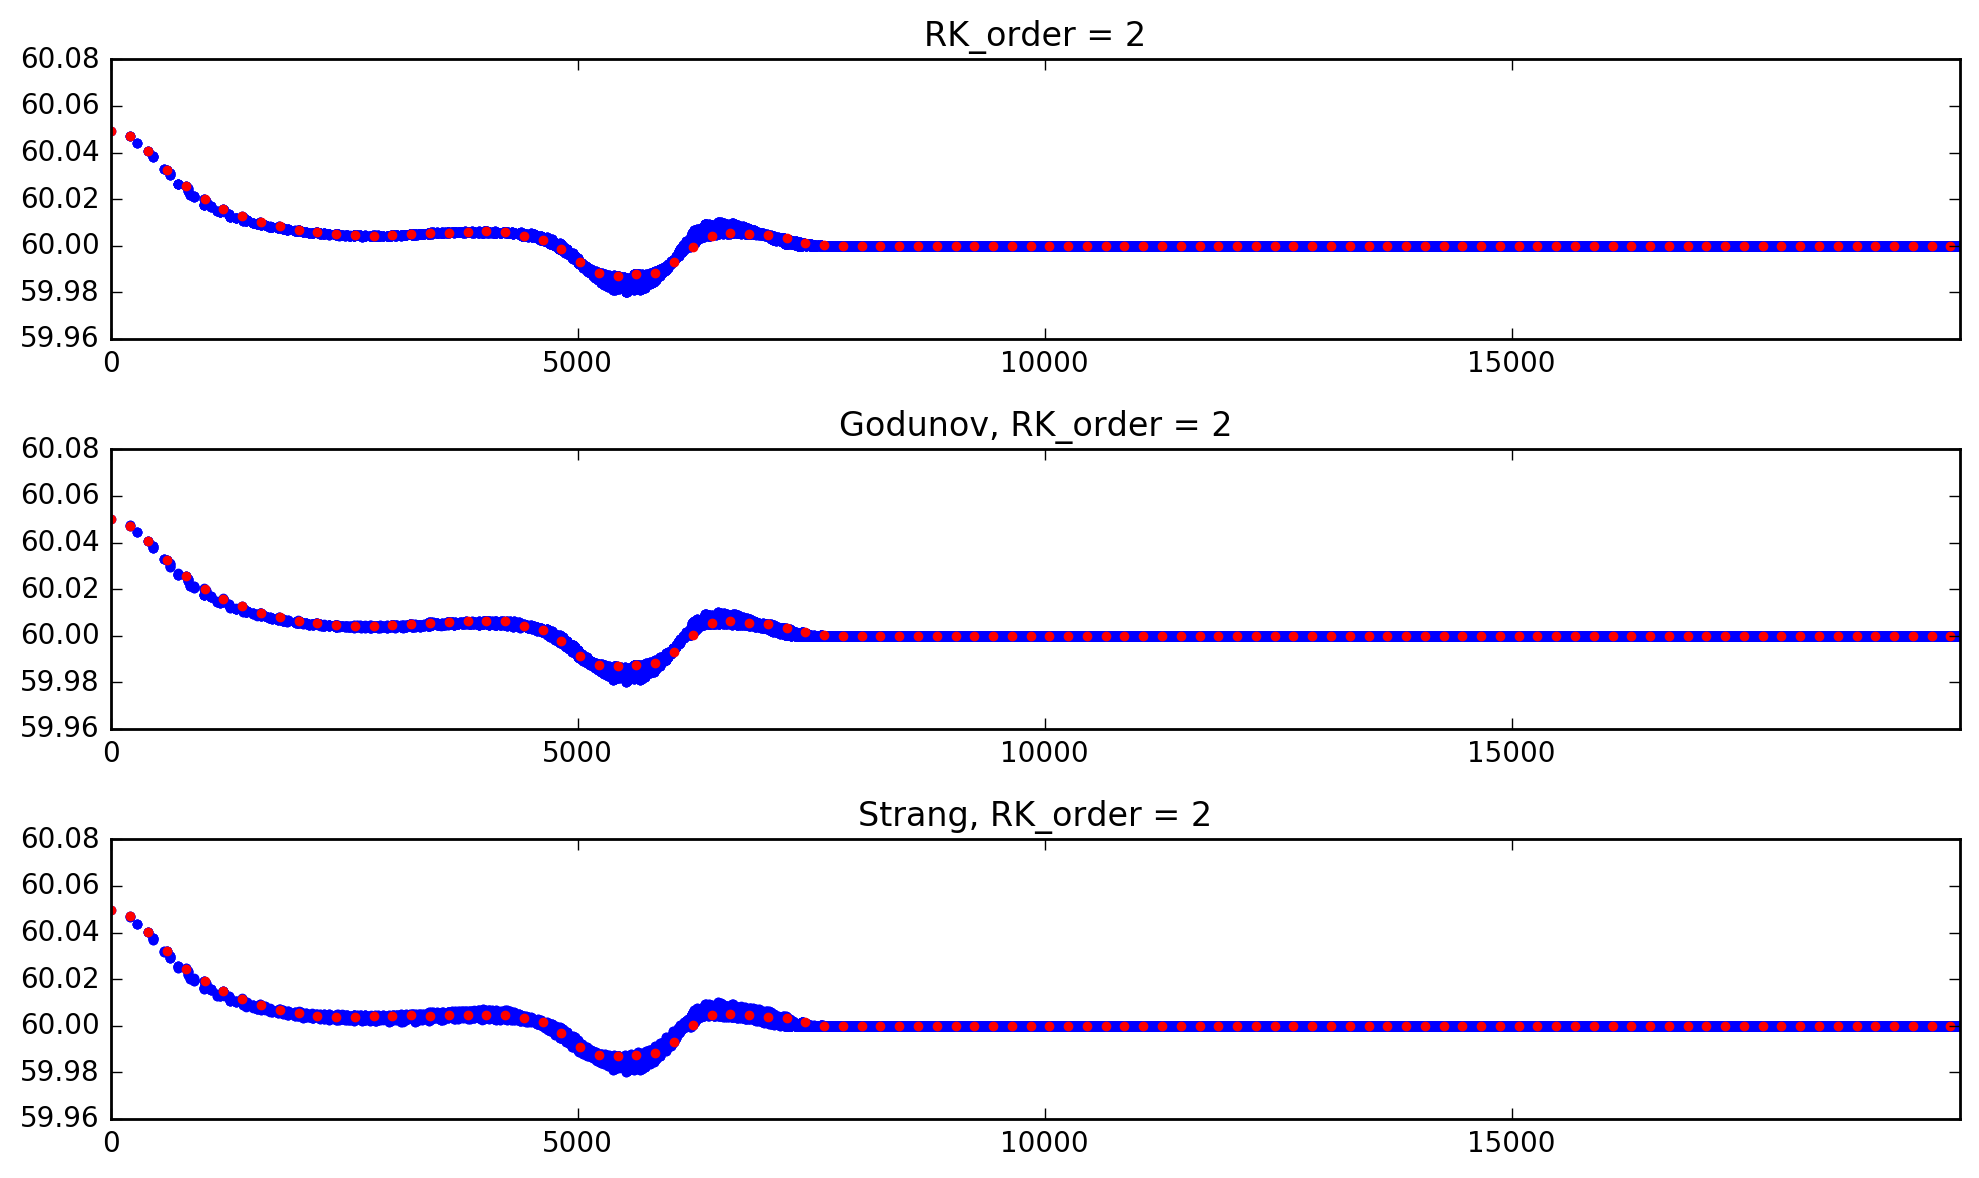

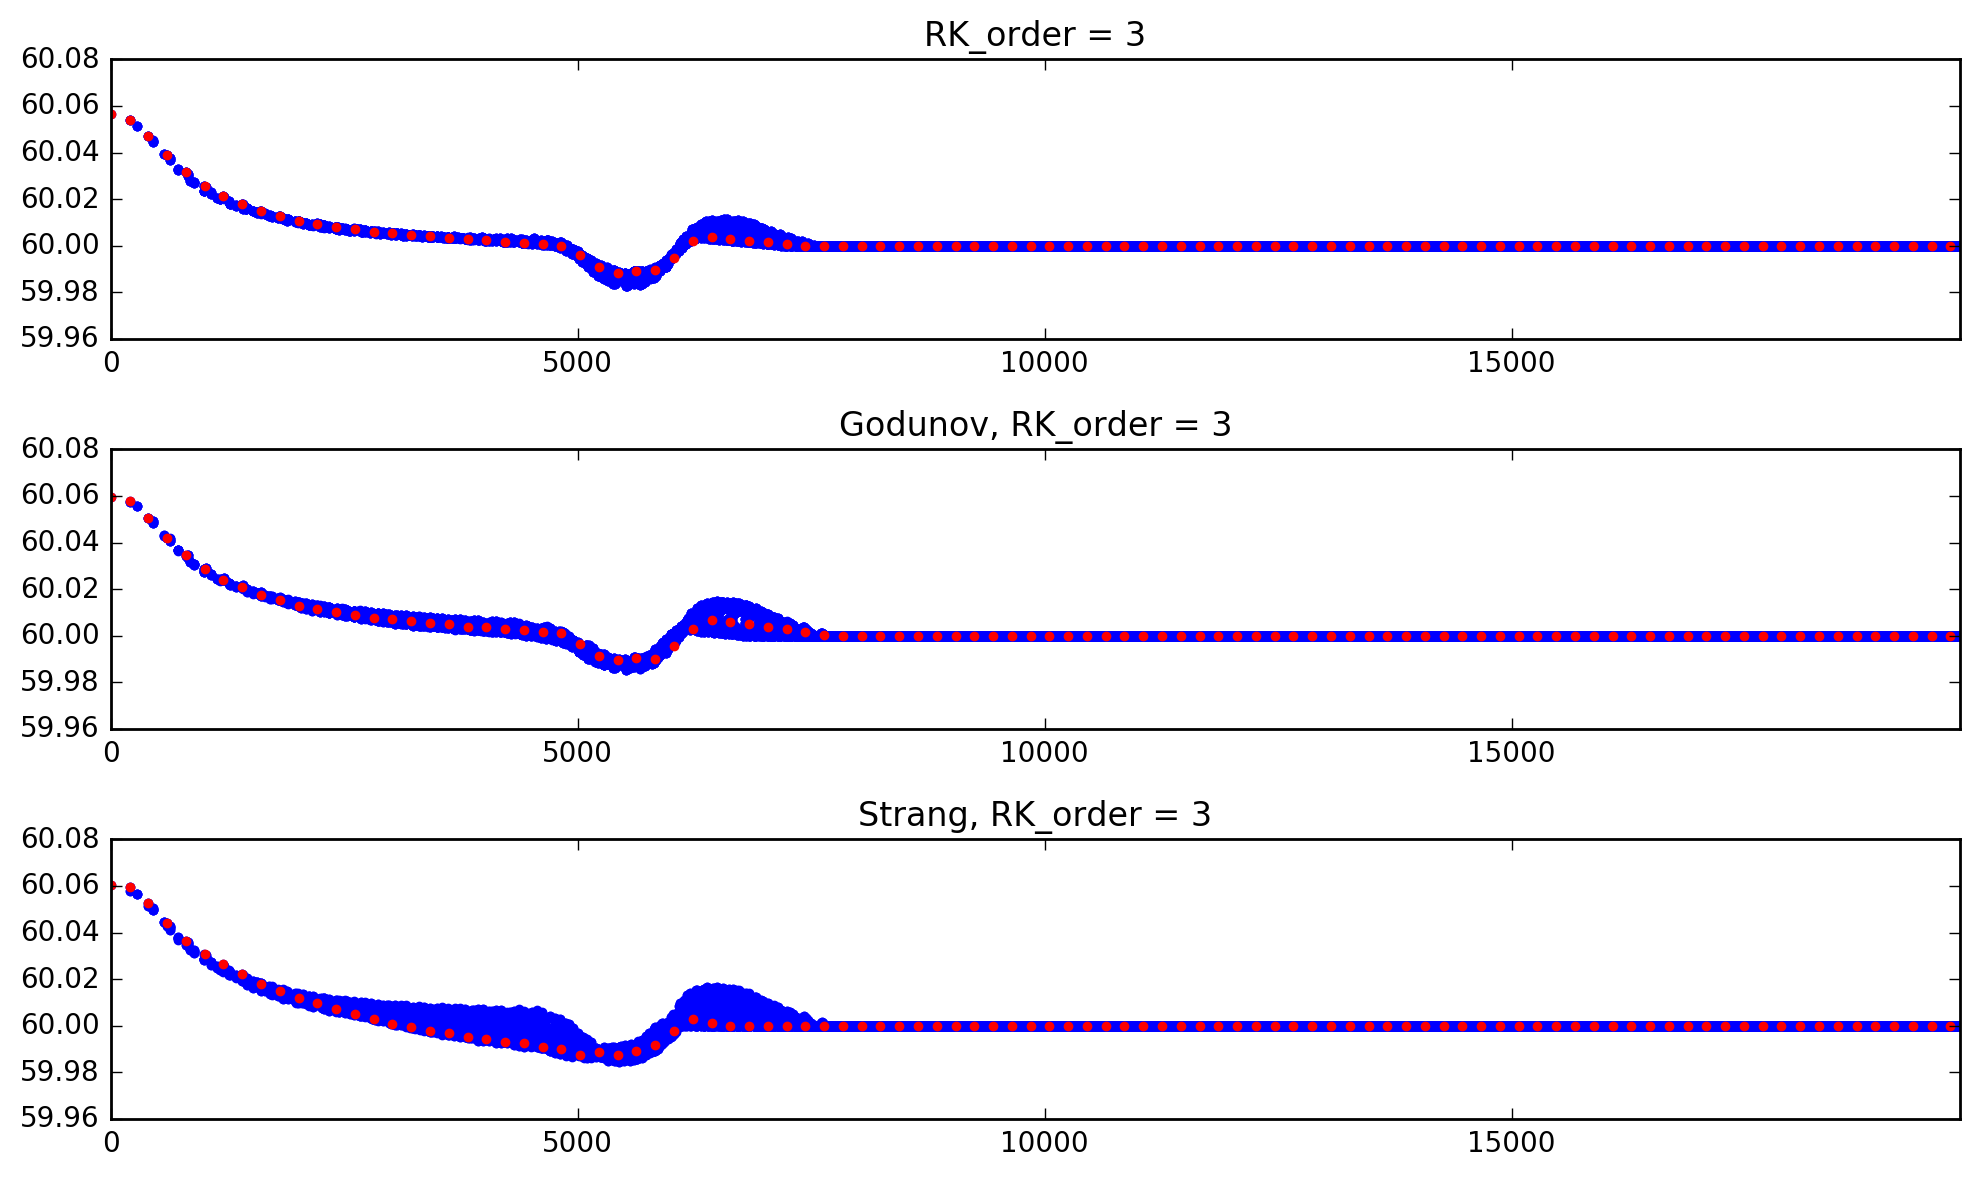

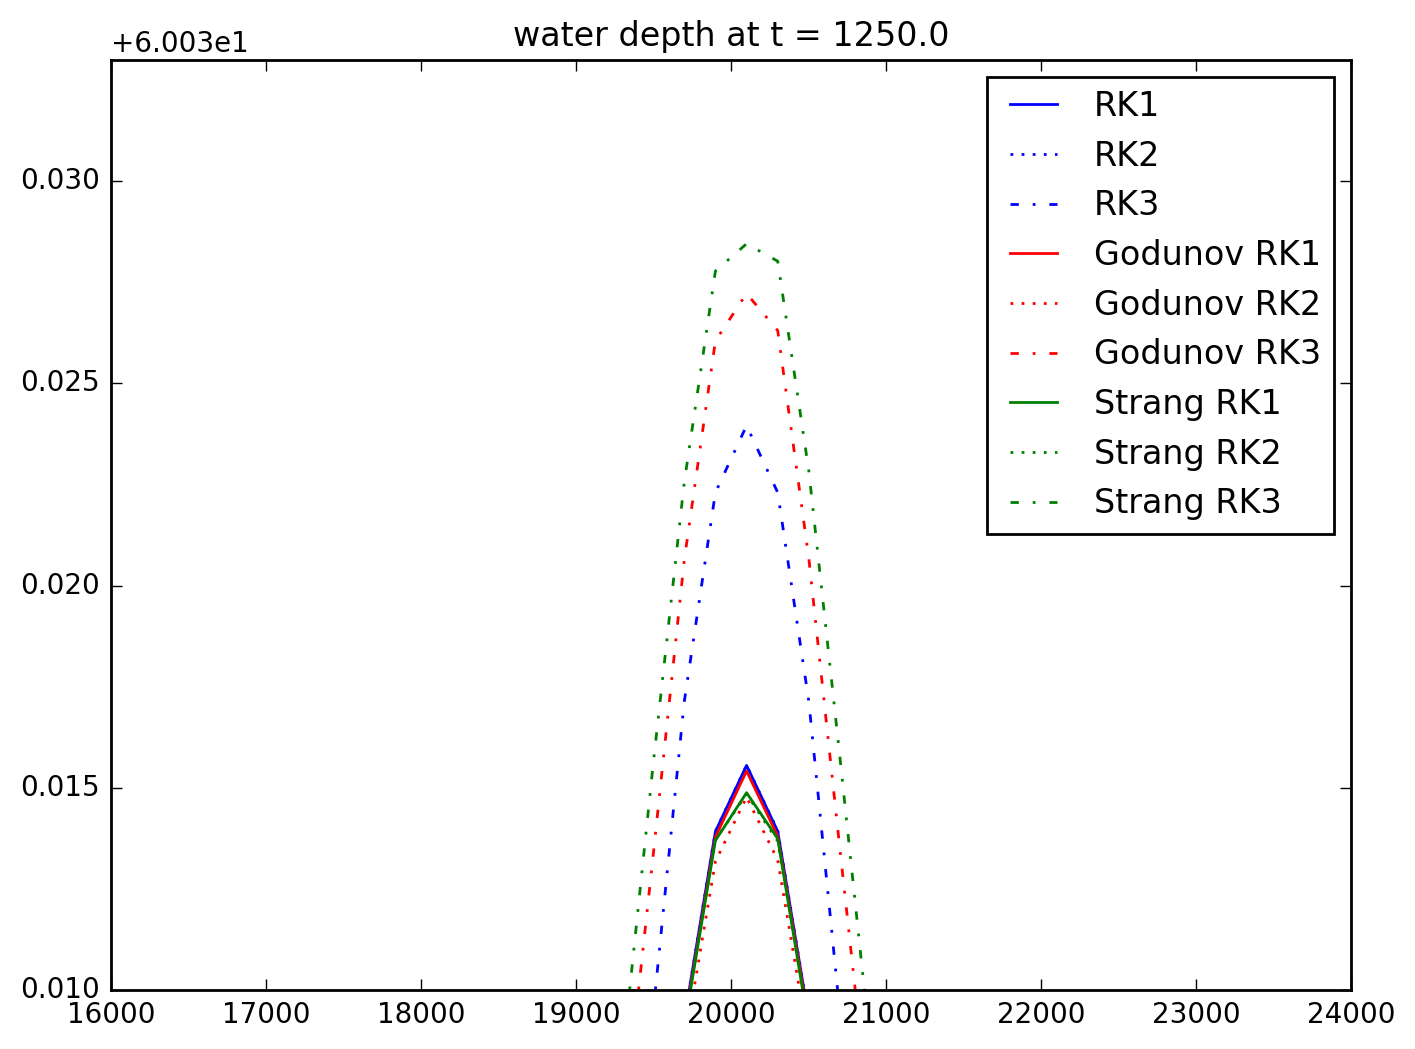

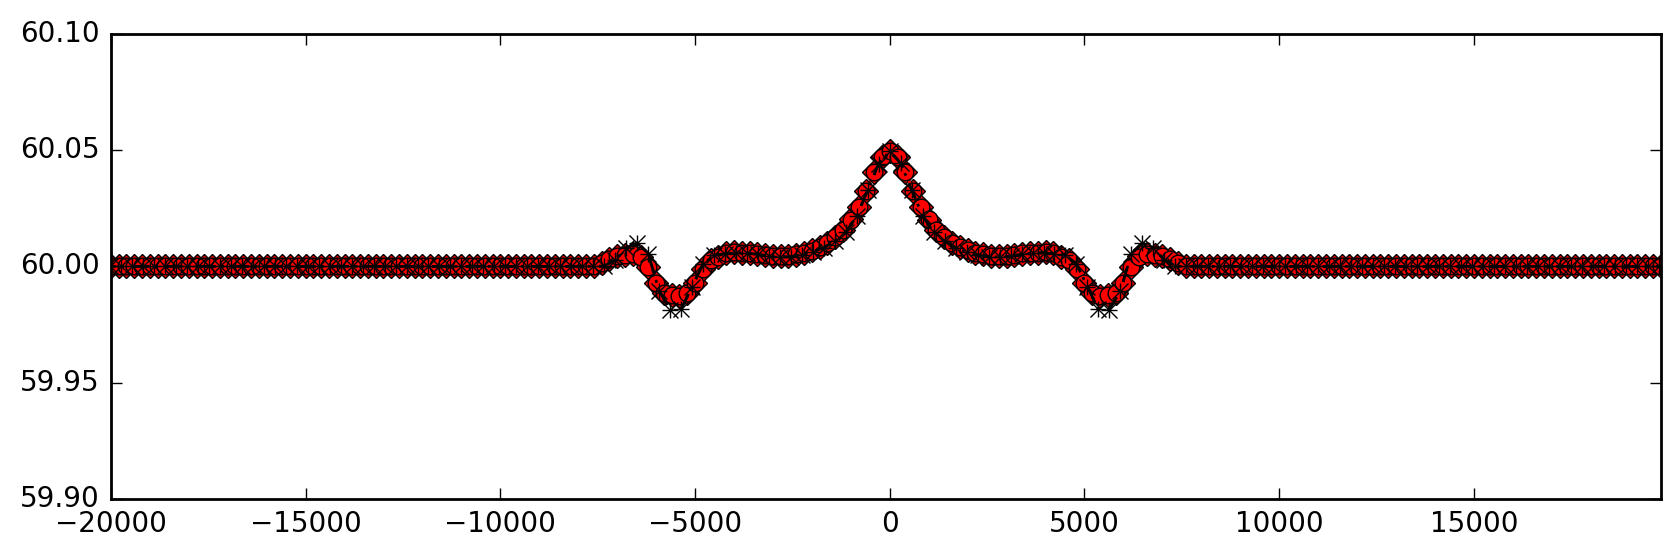

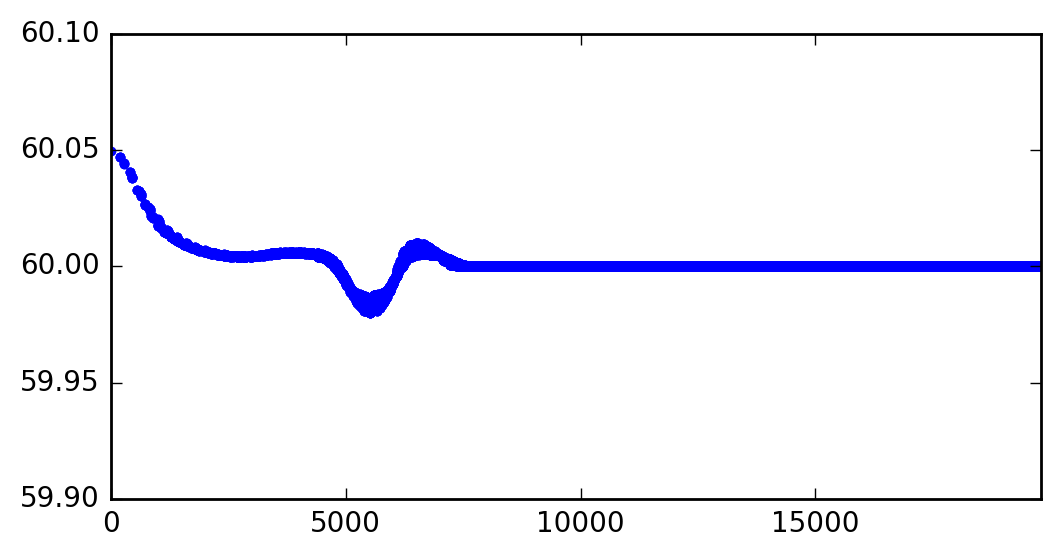

In [271]:
#Clean up old simulator if any:
if 'sim' in globals():
    sim.cleanUp()
    
#Coriolis well balanced reconstruction scheme
nx = 200
ny = 200

dx = 200.0
dy = 200.0

#dt = 0.1
#dt = 1.0
dt = 2.0/64
#dt = 0.5
print "dt: ", dt

g = 9.81

f = 0.02
r = 0.0

ghosts = np.array([10,10,10,10]) # north, east, south, west
validDomain = np.array([10,10,10,10])
boundaryConditions = Common.BoundaryConditions(3,3,3,3, spongeCells=ghosts)



#Calculate radius from center of bump for plotting
x_center = dx*nx/2.0
y_center = dy*ny/2.0
y_coords, x_coords = np.mgrid[0:ny*dy:dy, 0:nx*dx:dx]
x_coords = np.subtract(x_coords, x_center)
y_coords = np.subtract(y_coords, y_center)
radius = np.sqrt(np.multiply(x_coords, x_coords) + np.multiply(y_coords, y_coords))
min_x = np.min(x_coords[:,0]);
min_y = np.min(y_coords[0,:]);

max_x = np.max(x_coords[0,:]);
max_y = np.max(y_coords[:,0]);

dataShape = (ny + ghosts[0]+ghosts[2], 
             nx + ghosts[1]+ghosts[3])

waterHeight = 60
h0 = np.ones(dataShape, dtype=np.float32, order='C') * waterHeight;
u0 = np.zeros(dataShape, dtype=np.float32, order='C');
v0 = np.zeros(dataShape, dtype=np.float32, order='C');

# Bathymetry:
Bi = np.zeros((dataShape[0]+1, dataShape[1]+1), dtype=np.float32, order='C')
#diagonalWallBathymetry(Bi, nx, ny, dx, dy, ghosts, 50)
#makeBathymetryCrater(Bi, nx+1, ny+1, dx, dy, ghosts)

addCentralBump(h0, nx, ny, dx, dy, validDomain)


t1 = 250.0
#t2 = 850.0
t2 = 1250.0
timeString = " at t = " + str(t1)
mainFig = plt.figure(figsize=(8,7))
figh = plt.subplot(3,1,1)
plt.title("water depth"+timeString)
figu = plt.subplot(3,1,2)
plt.title("velocity"+timeString)
figShock = plt.subplot(3,1,3)
plt.title("water depth at t = " + str(t2))
plt.tight_layout()

splitFig = plt.figure(figsize=(16,4))
figRK1 = plt.subplot(1,3,1)
plt.title("Forward Euler (RK1)")
plt.ylim(59.99, 60.07)
plt.grid()
figRK2 = plt.subplot(1,3,2)
plt.title("2rd order Runge-Kutta (RK2)")
plt.ylim(59.99, 60.07)
plt.grid()
figRK3 = plt.subplot(1,3,3)
plt.title("3nd order Runge-Kutta (RK3)")
plt.ylim(59.99, 60.07)
plt.grid()
plt.tight_layout()

scatterFig = plt.figure(figsize=(9, 10))

scatterFigRK1 = plt.figure(figsize=(10, 6))
scatterFigRK2 = plt.figure(figsize=(10, 6))
scatterFigRK3 = plt.figure(figsize=(10, 6))




zoomFig = plt.figure(figsize=(8, 6))
plt.title("water depth at t = " + str(t2))


x = np.linspace(0.0, nx*dx, num=nx)

h1_2_2 = None
h2_2_2 = None
reload(CDKLM16)
for dim_split in range(3):
    for rk_order in range(1,4):
        
        print "Starting (dim_split, rk_order)", (dim_split, rk_order)
    
        label = "RK" + str(rk_order)
        color = 'b'
        symbol = '-'
        if (dim_split == 1):
            color = 'r'
            label = "Godunov " + label
        elif (dim_split == 2):
            label = "Strang " + label
            color = 'g'
        if (rk_order == 2):
            symbol = ':'
        elif (rk_order == 3):
            symbol = '-.'

        #Initialize simulator
        sim = CDKLM16.CDKLM16(cl_ctx, \
                        h0, u0, v0, Bi, \
                        nx, ny, \
                        dx, dy, dt, \
                        g, f, r, \
                        boundary_conditions=boundaryConditions, \
                        rk_order=rk_order, dim_split=dim_split)

        t = sim.step(t1)
        h1, u1, v1 = sim.download()
        
        plt.figure(mainFig.number)
        
        h = h1[(ny+20)/2, 10:-10]
        u = u1[(ny+20)/2, 10:-10]/h
        figh = plt.subplot(3,1,1)
        plt.plot(x, h, color+symbol, label=label)
        figh = plt.subplot(3,1,2)
        plt.plot(x, u, color+symbol, label=label)
        
        #fig = plt.figure()
        #plotter = PlotHelper.PlotHelper(fig, x_coords, y_coords, radius, 
        #                                h1[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]] - waterHeight, 
        #                                u1[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]], 
        #                                v1[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]])

        t = sim.step(t2-t1)
        h2, u2, v2 = sim.download()

        #h = h2[(ny+20)/2, 10:-10]
        h = h2[10:-10, (nx+20)/2]
        figh = plt.subplot(3,1,3)
        #if dim_split < 2:
        plt.plot(x, h, color+symbol, label=label)
        #fig = plt.figure()
        #plotter = PlotHelper.PlotHelper(fig, x_coords, y_coords, radius, 
        #                                h2[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]] - waterHeight, 
        #                                np.sqrt(u2[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]]**2 +  
        #                                 + v2[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]]**2), \
        #                              v2[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]])

        
        plt.figure(zoomFig.number)
        #if dim_split == 0 and rk_order > 1:
        plt.plot(x[80:-80], h[80:-80], color+symbol, label=label)
        
        if rk_order == 2 and dim_split == 0:
            h1_2_2 = np.copy(h1[10:-10,10:-10])
            h2_2_2 = np.copy(h2[10:-10,10:-10])
            
        plt.figure(scatterFig.number)
        plt.subplot(3,3, 3*dim_split + rk_order)
        sp_radial1, = plt.plot(radius.ravel(), h1[10:-10, 10:-10].ravel(), '.')
        sp_radial1, = plt.plot(x[0:nx/2], h1[ny/2+10, nx/2+10:-10], '.r')
        plt.axis([0, min(max_x, max_y), 59.9, 60.1])
        split = ""
        if (dim_split == 1):
            split = "Godunov, "
        elif (dim_split == 2):
            split = "Strang, "
        plt.title(split + "RK_order = " + str(rk_order))
  
        if rk_order == 1:
            plt.figure(scatterFigRK1.number)
        elif rk_order == 2:
            plt.figure(scatterFigRK2.number)
        elif rk_order == 3:
            plt.figure(scatterFigRK3.number)
        plt.subplot(3,1, dim_split + 1)
        sp_radial1, = plt.plot(radius.ravel(), h1[10:-10, 10:-10].ravel(), '.')
        sp_radial1, = plt.plot(x[0:nx/2], h1[ny/2+10, nx/2+10:-10], '.r')
        plt.axis([0, min(max_x, max_y), 59.96, 60.08])
        plt.title(split + "RK_order = " + str(rk_order))
            
        plt.figure(splitFig.number)
        plt.subplot(1,3, rk_order)
        plt.plot(x[70:-70], h[70:-70], color+symbol, label=label.replace("RK3", ""))
        
        print "Total amount of execive water: ", np.sum(np.sum(h2-60))
            
        sim.cleanUp()
        
plt.figure(mainFig.number)

plt.subplot(3,1,1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


fig = plt.figure(figsize=(10,3))
sp_x_axis1, = plt.plot(x_coords[ny/2,:], h1_2_2[ny/2,:], 'rD--', label='x-axis')
sp_y_axis1, = plt.plot(y_coords[:,nx/2], h1_2_2[:,nx/2], 'ro:', label='y-axis')
sp_x_diag1, = plt.plot(1.41*np.diagonal(x_coords, offset=-abs(nx-ny)/2), \
                           np.diagonal(h1_2_2, offset=-abs(nx-ny)/2), \
                           'k+--', label='x = -y')
sp_y_diag1, = plt.plot(1.41*np.diagonal(y_coords.T, offset=abs(nx-ny)/2), \
                           np.diagonal(h1_2_2.T, offset=abs(nx-ny)/2), \
                           'kx:', label='x = y')
plt.axis([max(min_x, min_y), min(max_x, max_y), 59.9, 60.1])

fig = plt.figure(figsize=(6,3))
sp_radial1, = plt.plot(radius.ravel(), h1_2_2.ravel(), '.')
plt.axis([0, min(max_x, max_y), 59.9, 60.1])

plt.figure(zoomFig.number)
plt.ylim(60.04, 60.063)
plt.legend()

plt.figure(scatterFigRK1.number)
plt.tight_layout()
plt.figure(scatterFigRK2.number)
plt.tight_layout()
plt.figure(scatterFigRK3.number)
plt.tight_layout()

2.06040447048
(9, 200, 200)
60.0521621704


(80, 80)

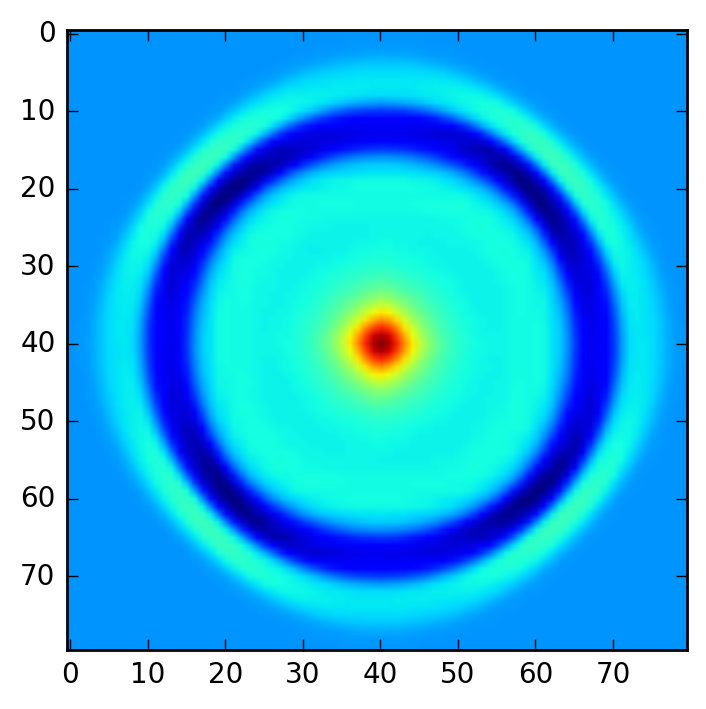

In [170]:
# CFL condition:
max_speed = 0.006
max_dt = 0.25 * dx /(max_speed  + np.sqrt(g*waterHeight))
print max_dt
allShortTermh = np.zeros((9, ny, nx))
print allShortTermh.shape
allShortTermh[0,:,:] = h1[10:-10, 10:-10]
print np.max(allShortTermh)
fig = plt.figure(figsize=(4,4))
plt.imshow(allShortTermh[0,60:-60,60:-60])
allShortTermh[0,60:-60,60:-60].shape

# Comparing step sizes for RK2 and RK3 only

Starting (rk_order, step_size_reduction) (1, 1)
Total amount of execive water:  98.9835
Starting (rk_order, step_size_reduction) (1, 1)
Total amount of execive water:  98.9835
Starting (rk_order, step_size_reduction) (1, 1)
Total amount of execive water:  98.9835
Starting (rk_order, step_size_reduction) (2, 1)
Total amount of execive water:  98.9835
Starting (rk_order, step_size_reduction) (2, 1)
Total amount of execive water:  98.9835
Starting (rk_order, step_size_reduction) (2, 1)
Total amount of execive water:  98.9835
Starting (rk_order, step_size_reduction) (3, 1)
Total amount of execive water:  98.9835
Starting (rk_order, step_size_reduction) (3, 1)
Total amount of execive water:  98.9835
Starting (rk_order, step_size_reduction) (3, 1)
Total amount of execive water:  98.9835
Starting (rk_order, step_size_reduction) (1, 2)
Total amount of execive water:  98.9835
Starting (rk_order, step_size_reduction) (1, 2)
Total amount of execive water:  98.9835
Starting (rk_order, step_size_re

(-0.025, 0.025)

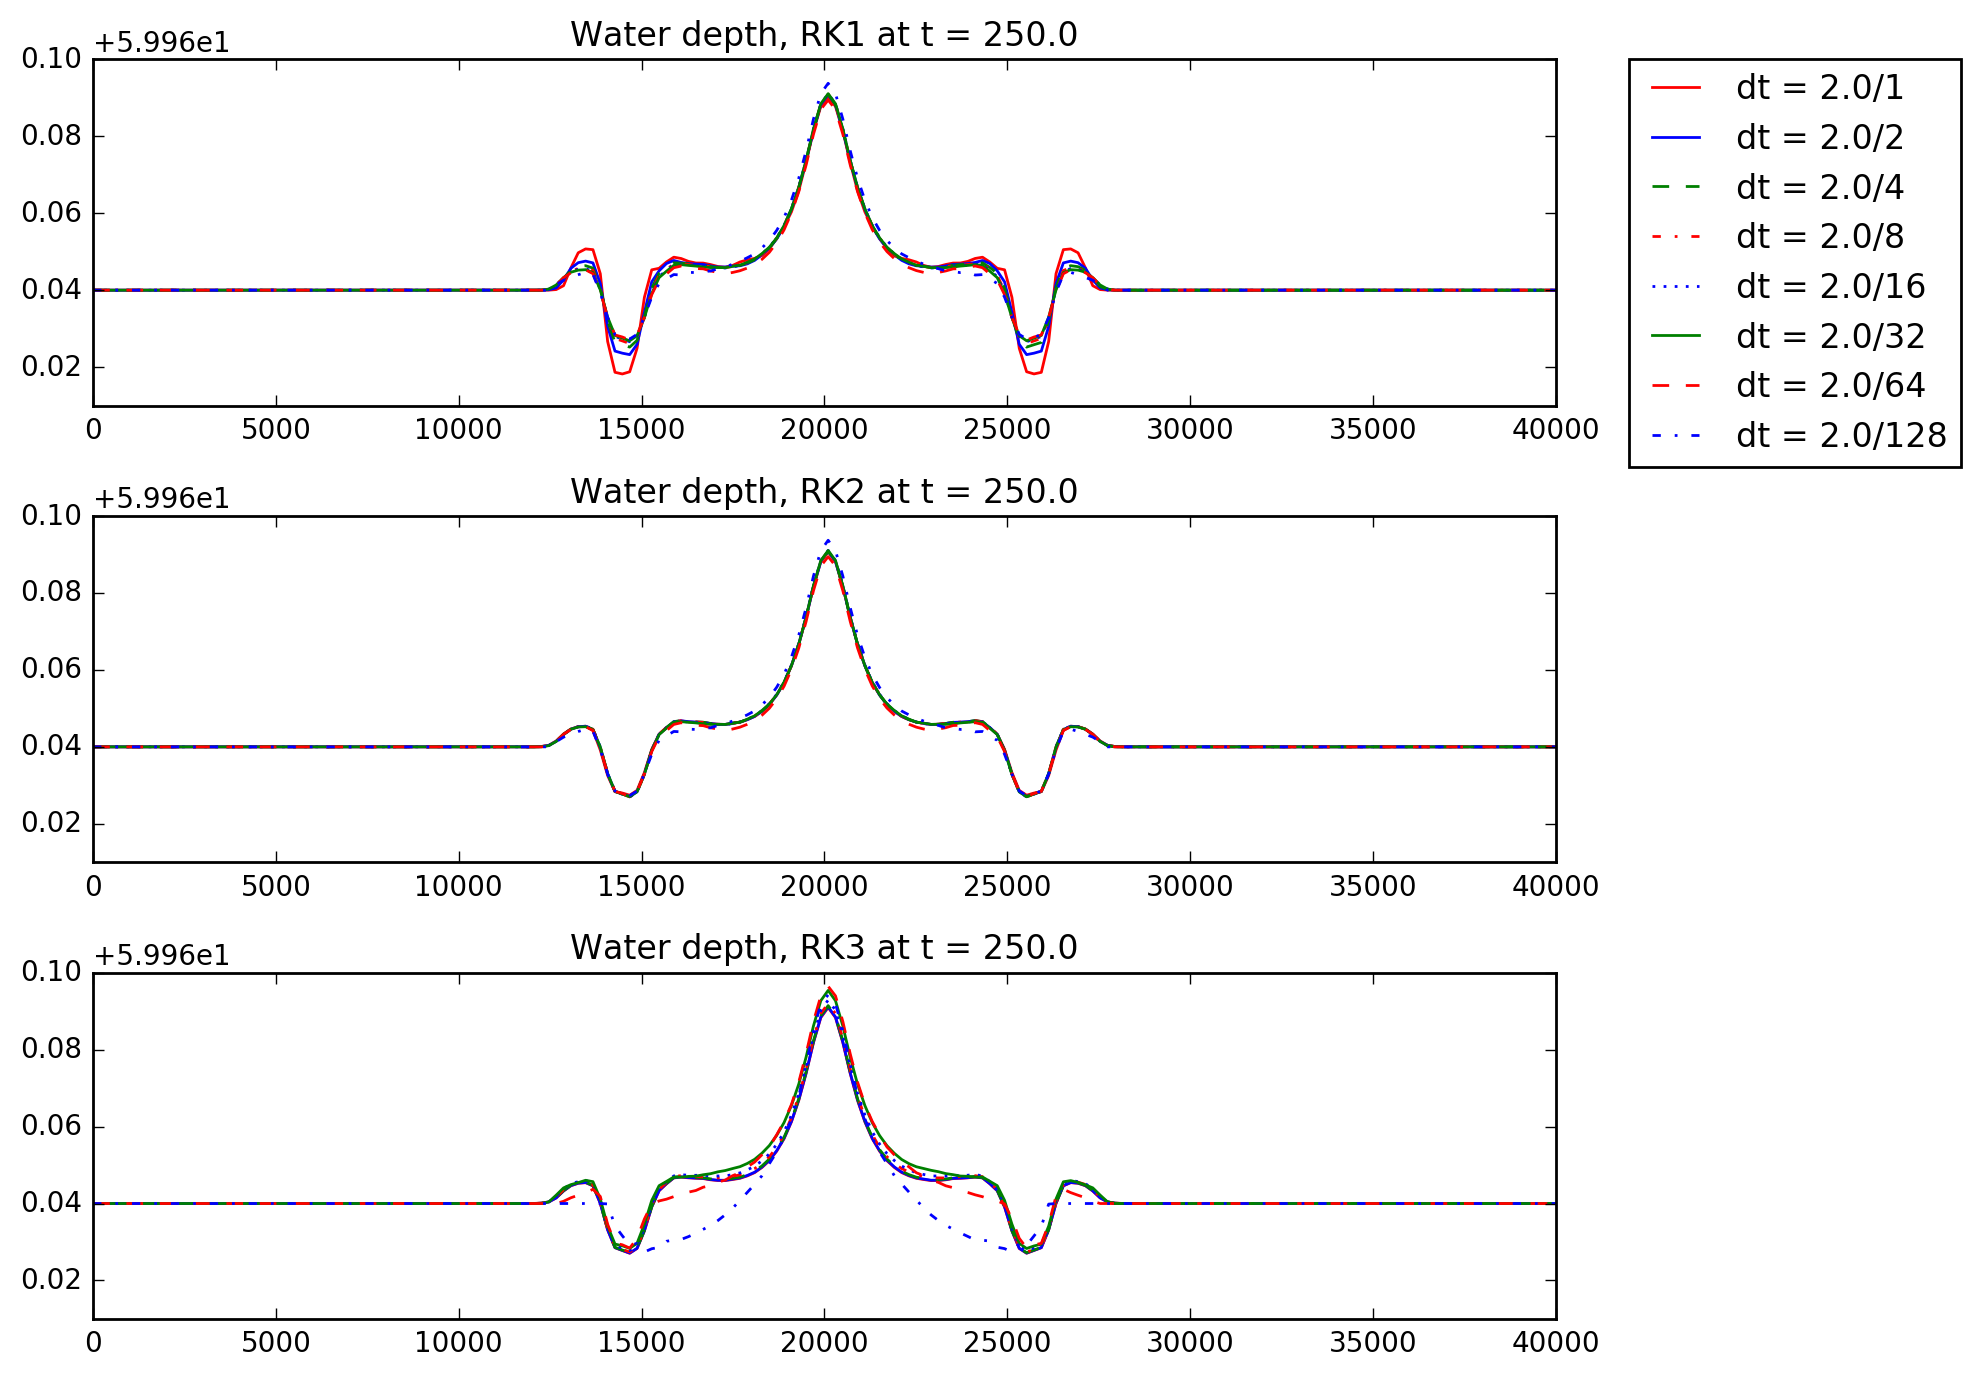

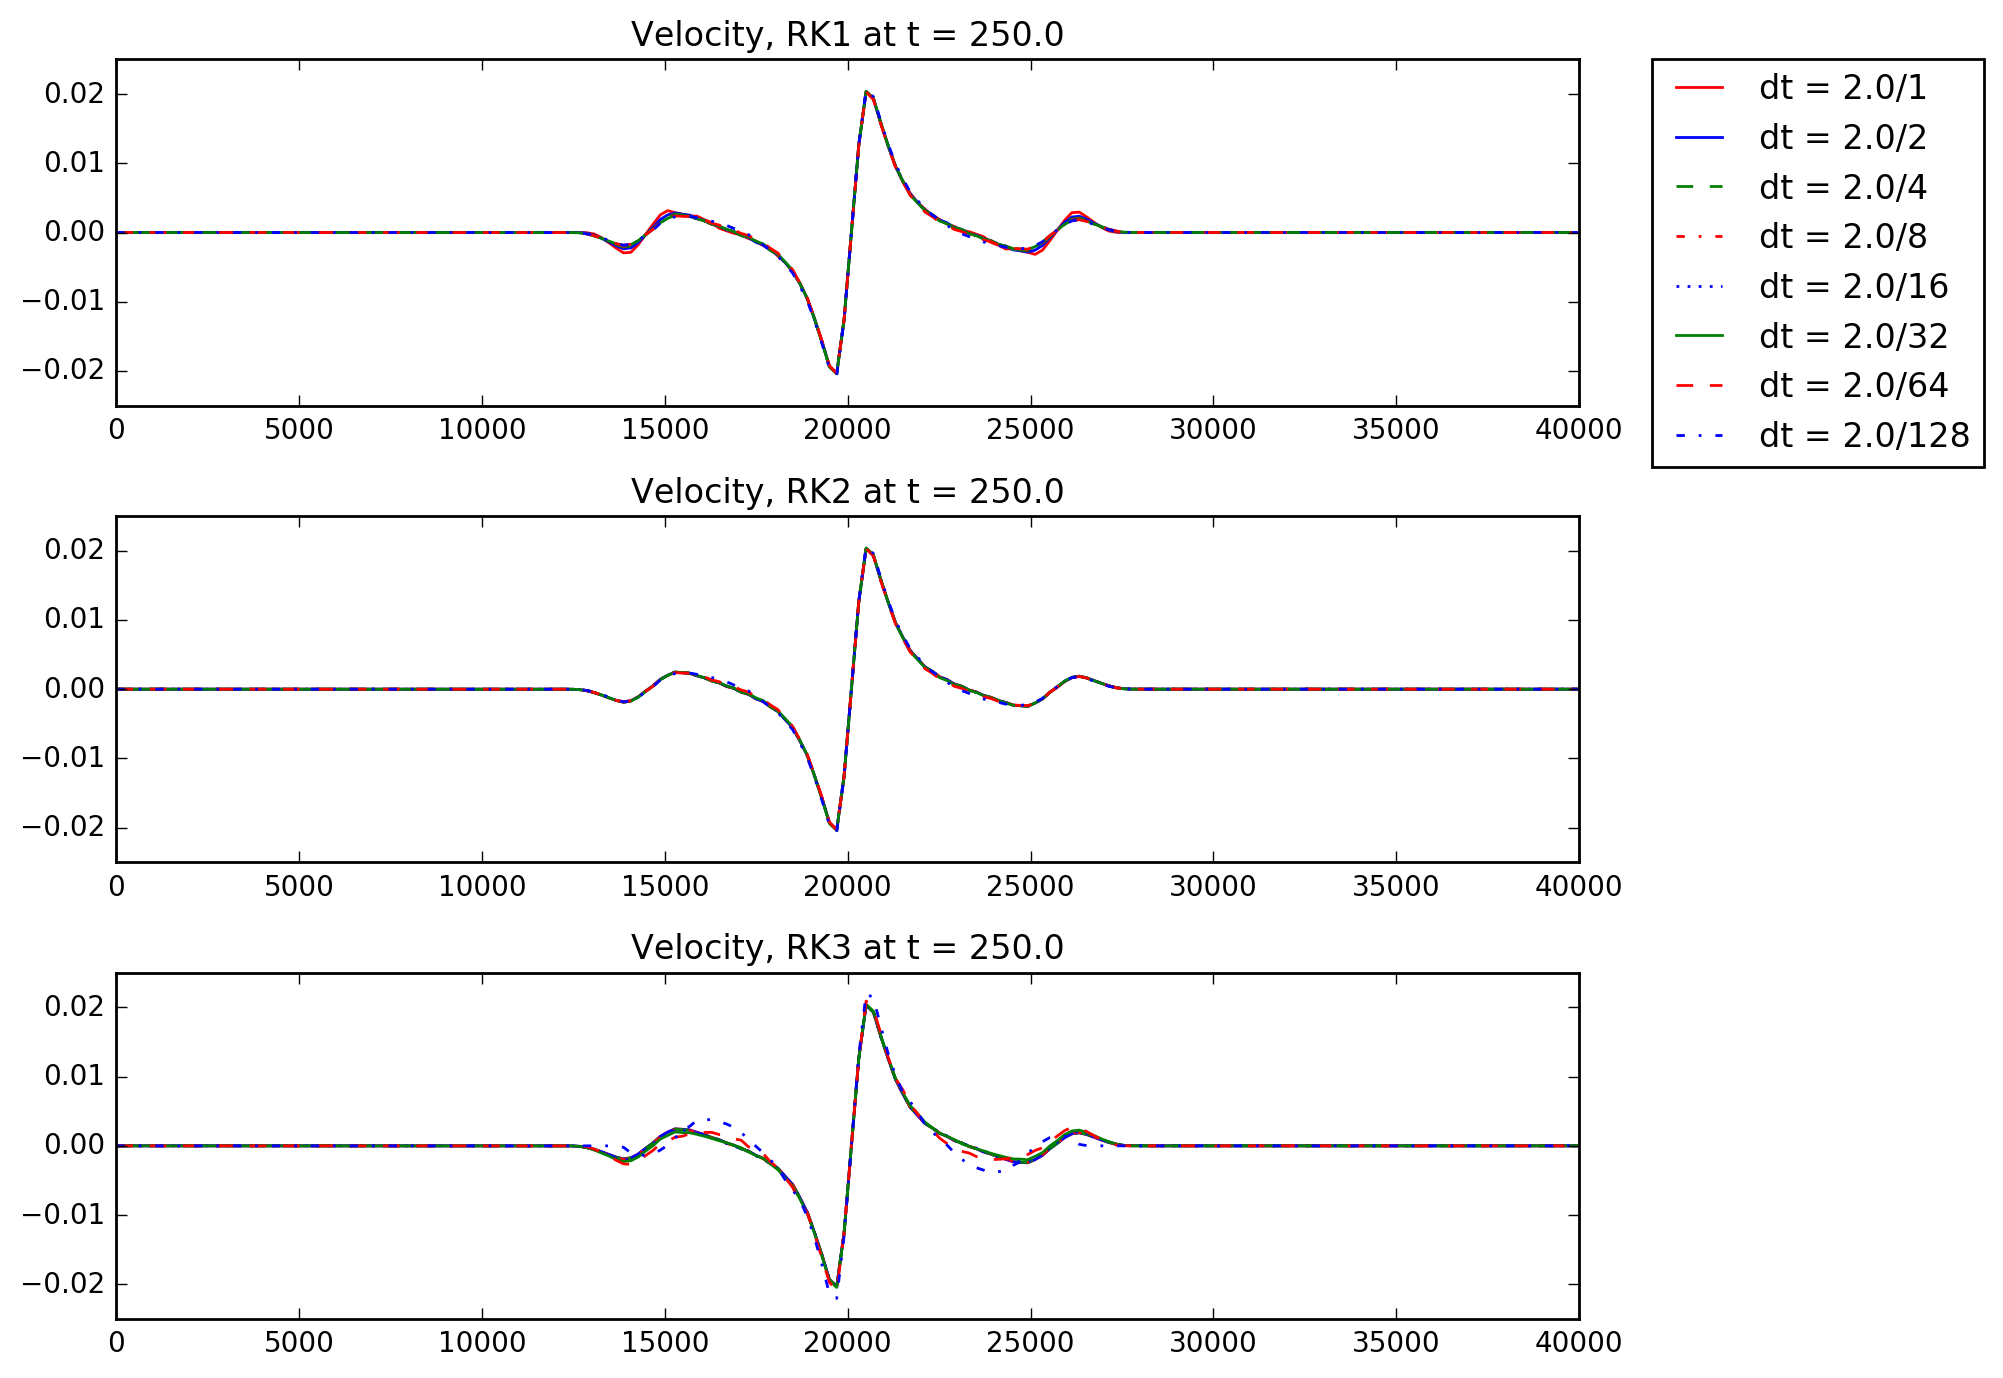

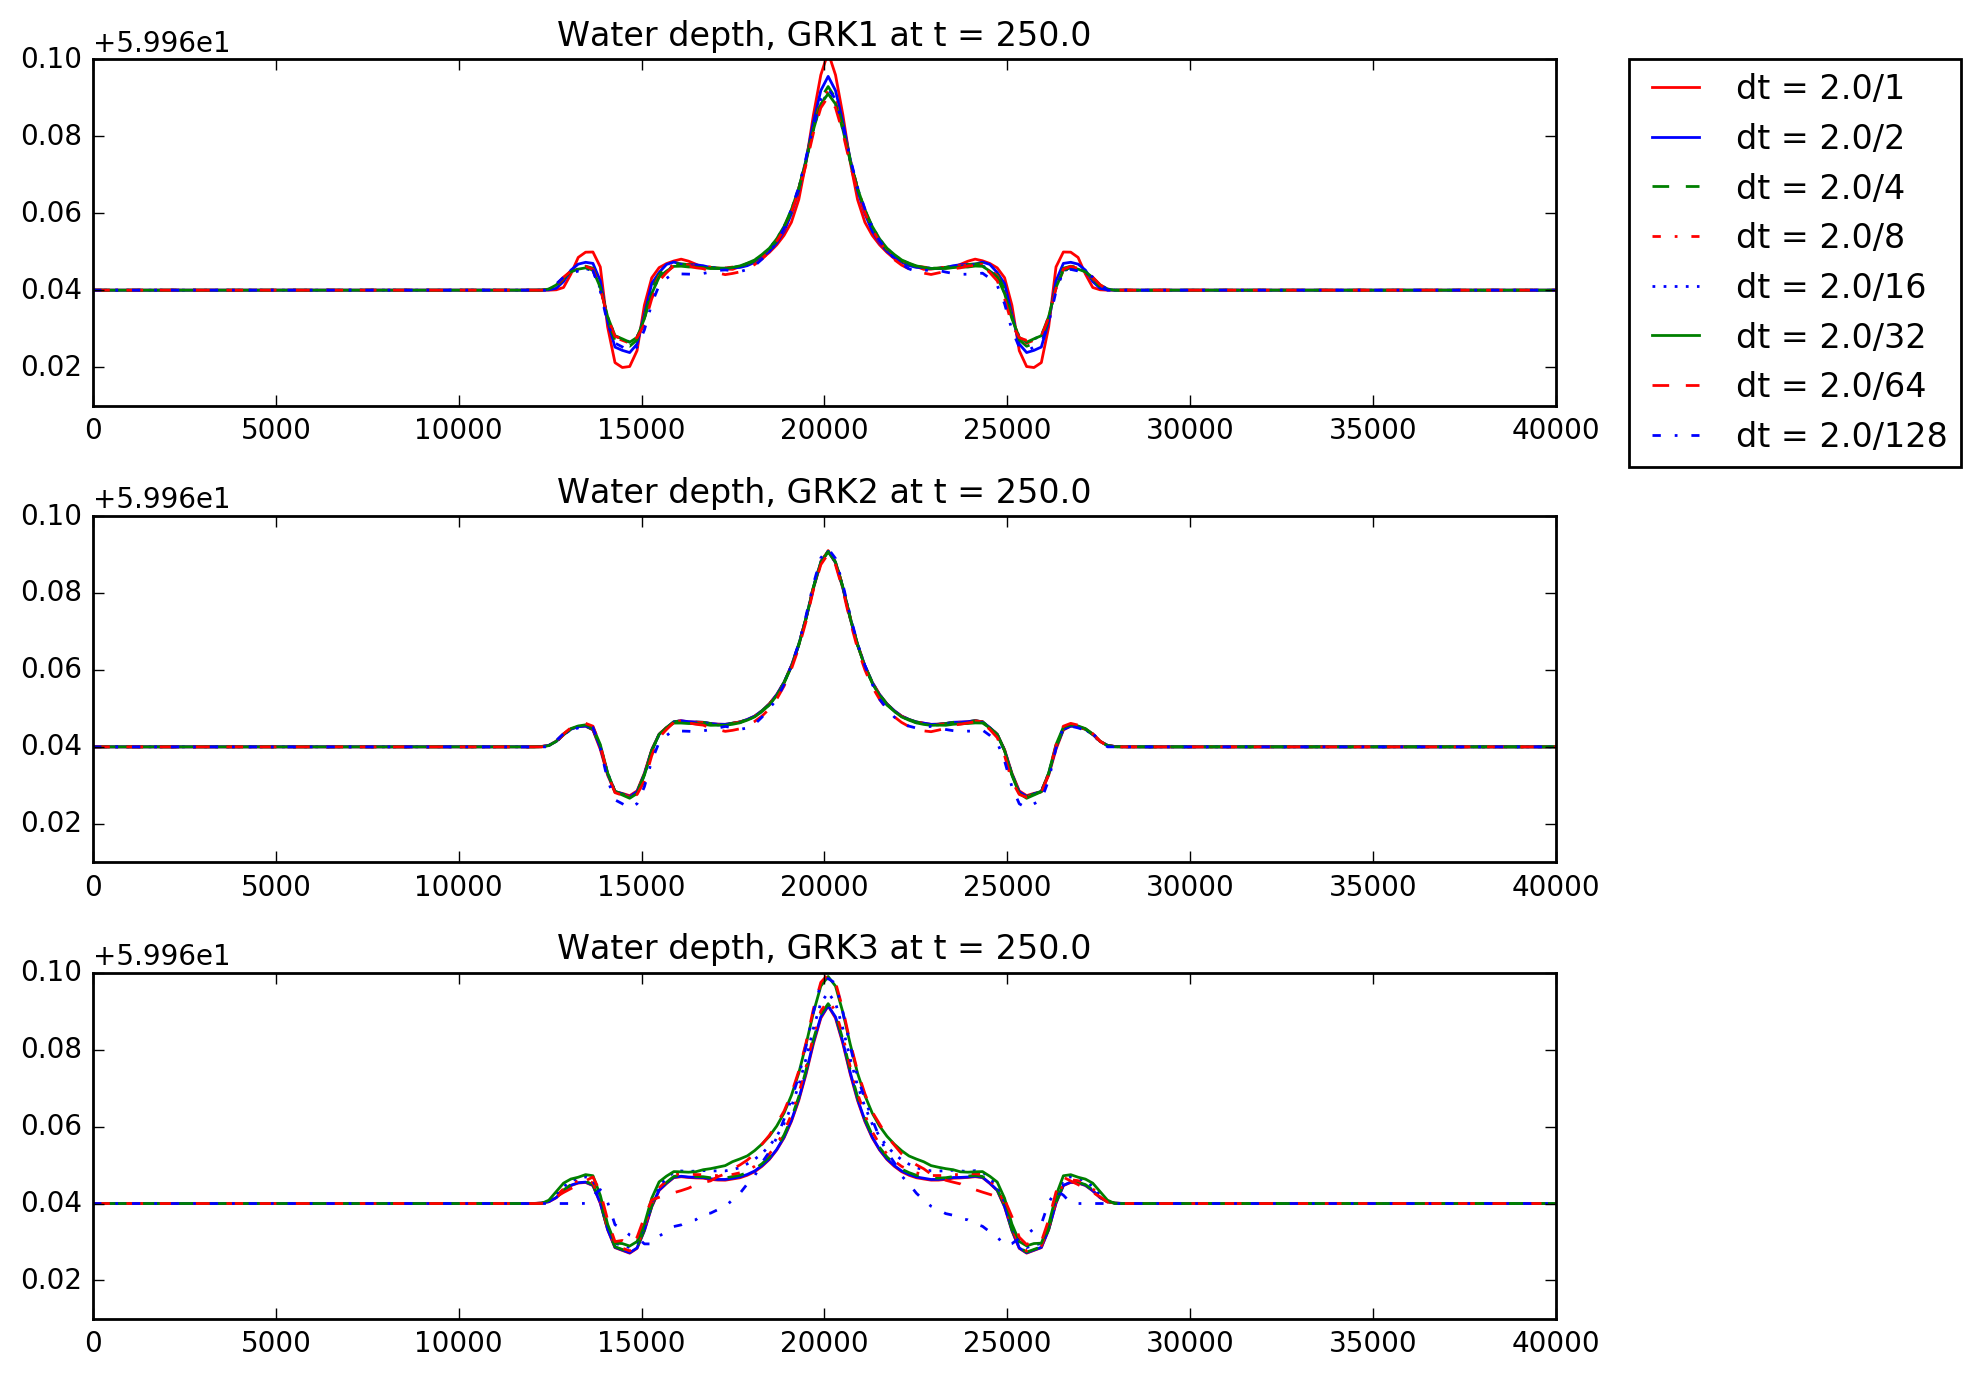

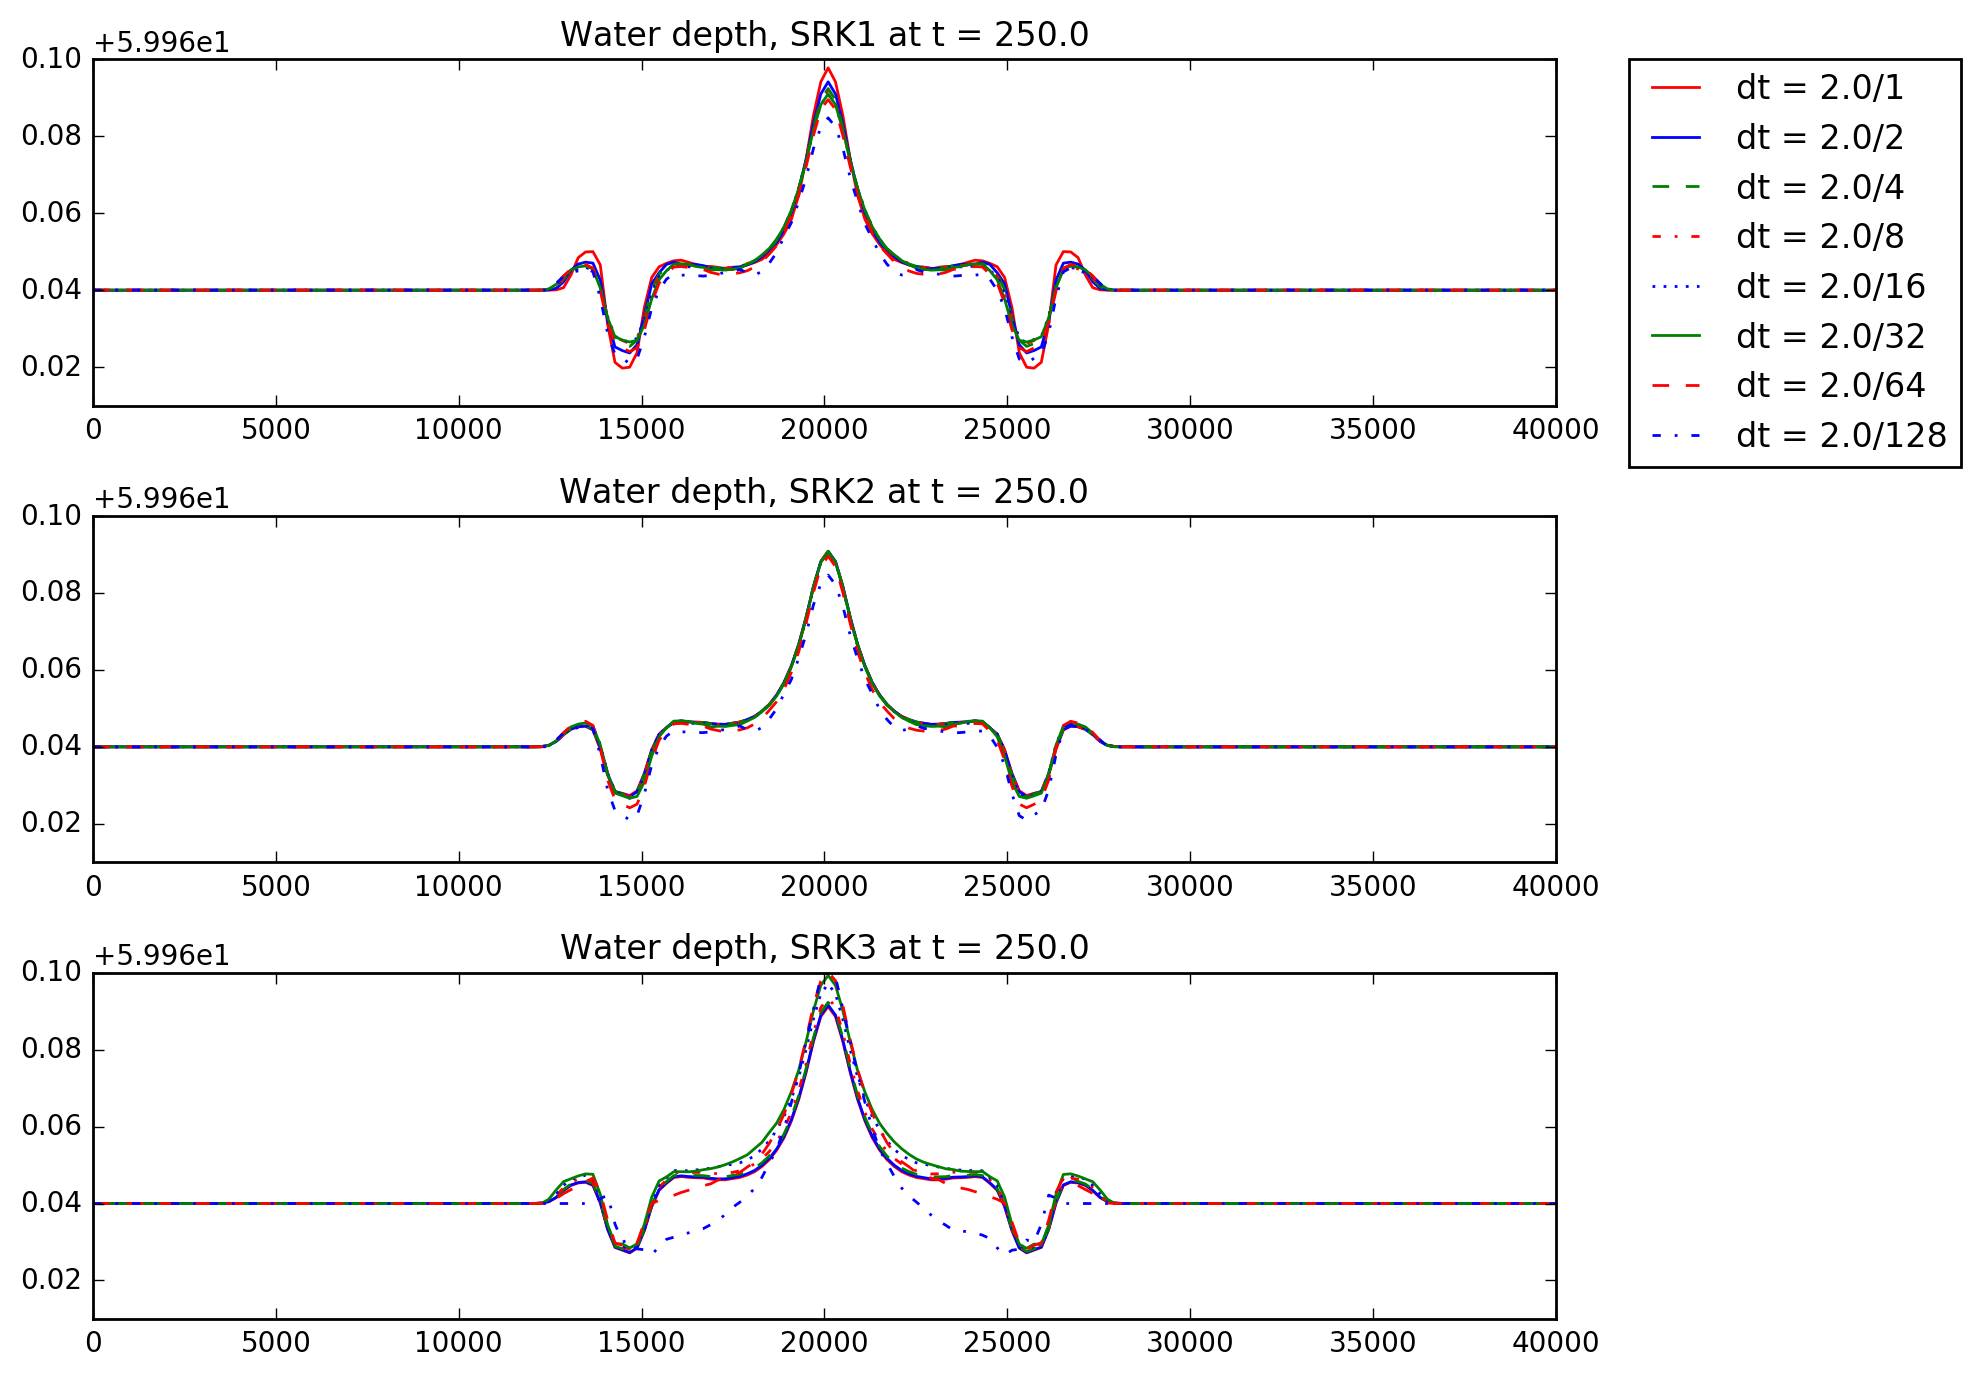

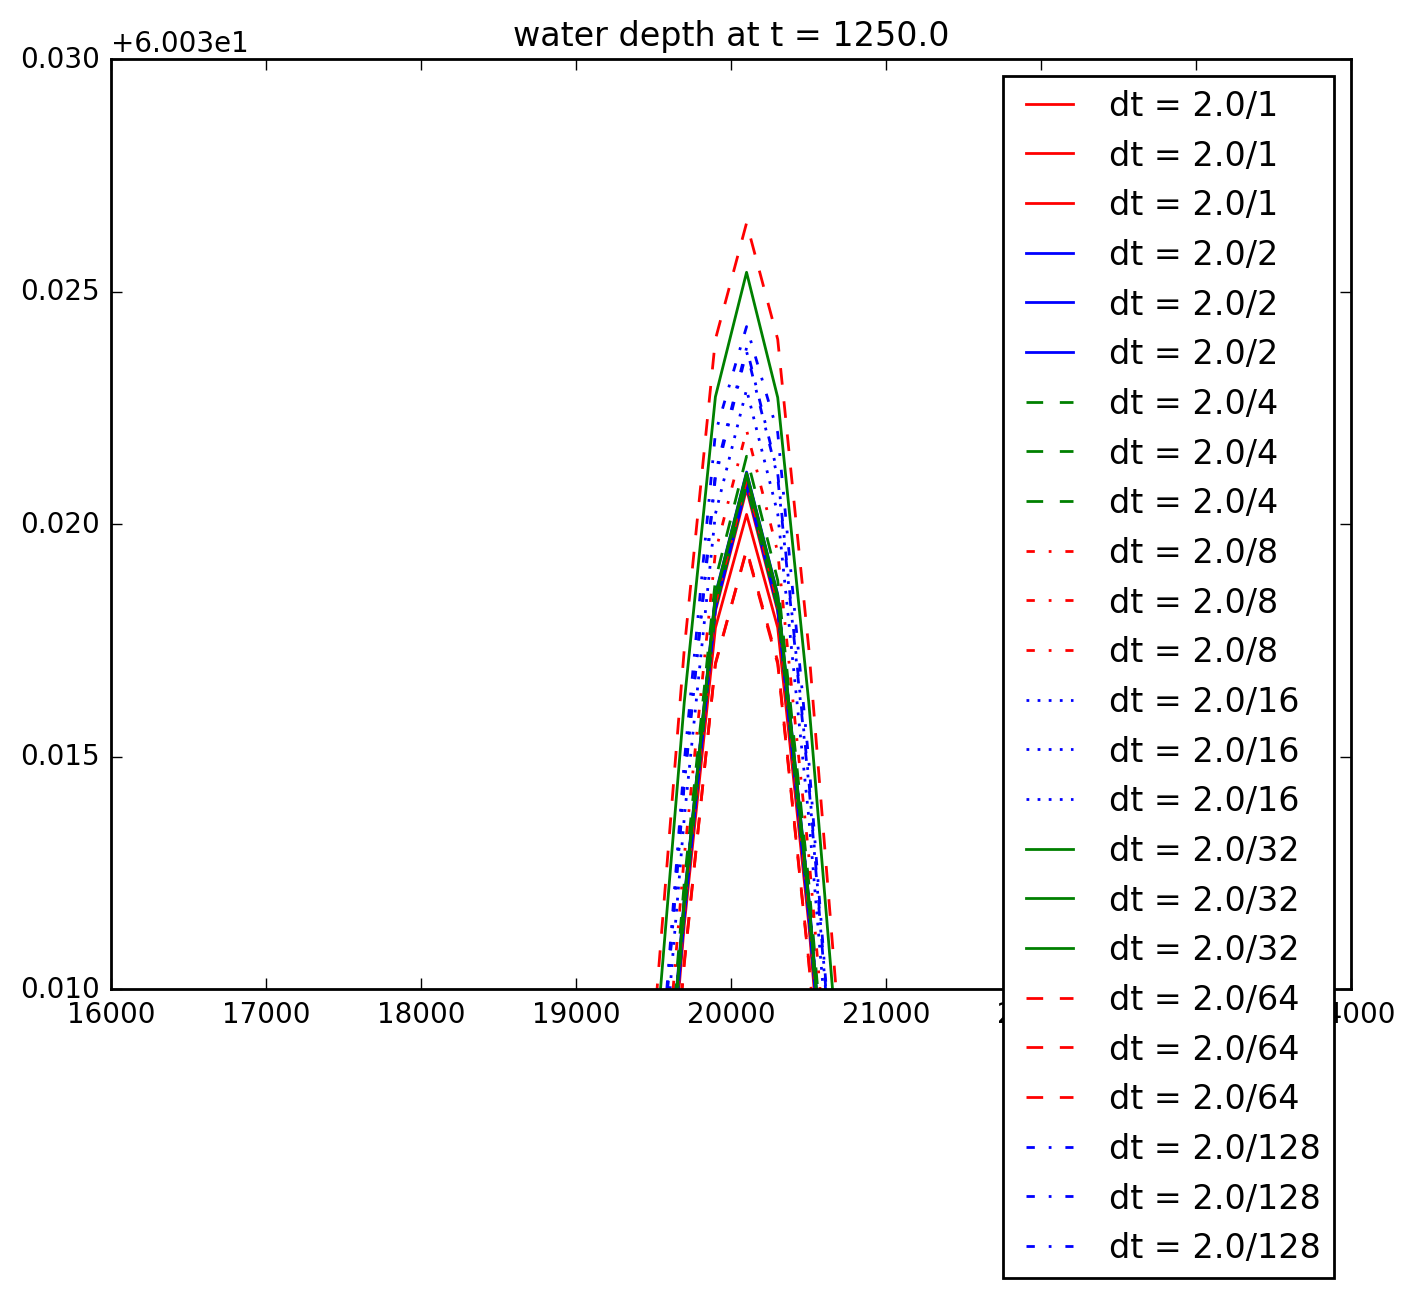

In [251]:
#Clean up old simulator if any:
if 'sim' in globals():
    sim.cleanUp()
    
#Coriolis well balanced reconstruction scheme
nx = 200#+16
ny = 200#+16

dx = 200.0
dy = 200.0

g = 9.81

f = 0.02
r = 0.0

ghosts = np.array([10,10,10,10]) # north, east, south, west
validDomain = np.array([10,10,10,10])
boundaryConditions = Common.BoundaryConditions(3,3,3,3, spongeCells=ghosts)

#ghosts = np.array([2,2,2,2])
#validDomain = np.array([2,2,2,2])
#boundaryConditions = Common.BoundaryConditions(1,1,1,1)


#Calculate radius from center of bump for plotting
x_center = dx*nx/2.0
y_center = dy*ny/2.0
y_coords, x_coords = np.mgrid[0:ny*dy:dy, 0:nx*dx:dx]
x_coords = np.subtract(x_coords, x_center)
y_coords = np.subtract(y_coords, y_center)
radius = np.sqrt(np.multiply(x_coords, x_coords) + np.multiply(y_coords, y_coords))
min_x = np.min(x_coords[:,0]);
min_y = np.min(y_coords[0,:]);

max_x = np.max(x_coords[0,:]);
max_y = np.max(y_coords[:,0]);



dataShape = (ny + ghosts[0]+ghosts[2], 
             nx + ghosts[1]+ghosts[3])

waterHeight = 60
h0 = np.ones(dataShape, dtype=np.float32, order='C') * waterHeight;
u0 = np.zeros(dataShape, dtype=np.float32, order='C');
v0 = np.zeros(dataShape, dtype=np.float32, order='C');

# Bathymetry:
Bi = np.zeros((dataShape[0]+1, dataShape[1]+1), dtype=np.float32, order='C')
#diagonalWallBathymetry(Bi, nx, ny, dx, dy, ghosts, 50)
#makeBathymetryCrater(Bi, nx+1, ny+1, dx, dy, ghosts)

# Staggered u and v
eta0 = np.zeros(dataShape, dtype=np.float32, order='C')
H0 = np.ones(dataShape, dtype=np.float32, order='C') * waterHeight;
u0s = np.zeros((dataShape[0], dataShape[1]+1), dtype=np.float32, order='C');
v0s = np.zeros((dataShape[0]+1, dataShape[1]), dtype=np.float32, order='C');
A = 1.0

addCentralBump(h0, nx, ny, dx, dy, validDomain)
addCentralBump(eta0, nx, ny, dx, dy, validDomain)
nx = nx# - 16
ny = ny# - 16

t1 = 250.0
#t2 = 850.0
t2 = 1250.0
timeString = " at t = " + str(t1)
mainFig = plt.figure(figsize=(8,7))
figh = plt.subplot(3,1,1)
plt.title("Water depth, RK1"+timeString)
figu = plt.subplot(3,1,2)
plt.title("Water depth, RK2"+timeString)
figShock = plt.subplot(3,1,3)
plt.title("Water depth, RK3"+timeString)
plt.tight_layout()

velocityFig = plt.figure(figsize=(8,7))
figh = plt.subplot(3,1,1)
plt.title("Velocity, RK1"+timeString)
figu = plt.subplot(3,1,2)
plt.title("Velocity, RK2"+timeString)
figShock = plt.subplot(3,1,3)
plt.title("Velocity, RK3"+timeString)
plt.tight_layout()

mainFigGodunov = plt.figure(figsize=(8,7))
figh = plt.subplot(3,1,1)
plt.title("Water depth, GRK1"+timeString)
figu = plt.subplot(3,1,2)
plt.title("Water depth, GRK2"+timeString)
figShock = plt.subplot(3,1,3)
plt.title("Water depth, GRK3"+timeString)
plt.tight_layout()

mainFigStrang = plt.figure(figsize=(8,7))
figh = plt.subplot(3,1,1)
plt.title("Water depth, SRK1"+timeString)
figu = plt.subplot(3,1,2)
plt.title("Water depth, SRK2"+timeString)
figShock = plt.subplot(3,1,3)
plt.title("Water depth, SRK3"+timeString)
plt.tight_layout()

zoomFig = plt.figure(figsize=(8, 6))
plt.title("water depth at t = " + str(t2))



x = np.linspace(0.0, nx*dx, num=nx)
step_size_reductions = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
symbols = ["-", "-", "--", "-.", ":", "-", "--", "-.", ":", ":" ]

h1_2_2 = None
h2_2_2 = None
reload(CDKLM16)
reload(CTCS)

numDts = 8
#allShortTermh = np.zeros((split, rk_order, numDts, ny, nx))
allShortTermh = np.zeros(( 3,     3,        numDts, 80, 80))
def storeResult(h, split, rk_order, dtNum):
    allShortTermh[split, rk_order-1, dtNum, :, :] = h[70:-70, 70:-70]
def readResult(split, rk_order, dtNum):
    return allShortTermh[split, rk_order-1, dtNum, :,:]


for i in range(numDts):#[2]:#range(4):
    for rk_order in [1, 2, 3]:
        for dim_split in [0,1,2]:
            step_size_reduction = step_size_reductions[i]
            symbol = symbols[i]

            base_dt = 2.0
            dt = base_dt/step_size_reduction


            color = 'r'
            if (i%3 == 1):
                color = 'b'
            elif (i%3 == 2):
                color = 'g'

            if (rk_order == 5):
                color = 'k'
                print "Starting CTCS with step_size_reduction",  step_size_reduction

                sim = CTCS.CTCS(cl_ctx, \
                           H0, eta0, u0s, v0s, \
                           nx, ny, \
                           dx, dy, dt, \
                           g, f, r, A, \
                           boundary_conditions=boundaryConditions)
                label = "CTCS, dt = 1.0/" + str(step_size_reduction)
            else:


                print "Starting (rk_order, step_size_reduction)", (rk_order, step_size_reduction)
                label = "dt = " + str(base_dt) + "/" + str(step_size_reduction)

                #Initialize simulator
                sim = CDKLM16.CDKLM16(cl_ctx, \
                                h0, u0, v0, Bi, \
                                #nx+16, ny+16, \
                                nx, ny, \
                                dx, dy, dt, \
                                g, f, r, \
                                boundary_conditions=boundaryConditions, \
                                rk_order=rk_order, dim_split=dim_split)

            
            t = sim.step(t1)
            h1, hu1, hv1 = sim.download()
            storeResult(h1, dim_split, rk_order, i)
            
            h = h1[10:-10, (nx+20)/2]
            u = hu1[10:-10, (nx+20)/2]/h
            if dim_split == 0:
                plt.figure(mainFig.number)

                figh = plt.subplot(3,1,rk_order)
                #if dim_split < 2:
                plt.plot(x, h, color+symbol, label=label)

                plt.figure(velocityFig.number)
                plt.subplot(3,1,rk_order)
                plt.plot(x, u, color+symbol, label=label)



                plt.figure(zoomFig.number)
                #if dim_split == 0 and rk_order > 1:
                plt.plot(x[80:-80], h[80:-80], color+symbol, label=label)

            elif dim_split == 1:
                plt.figure(mainFigGodunov.number)
                figh = plt.subplot(3,1,rk_order)
                plt.plot(x, h, color+symbol, label=label)
            elif dim_split == 2:
                plt.figure(mainFigStrang.number)
                figh = plt.subplot(3,1,rk_order)
                plt.plot(x, h, color+symbol, label=label)
         

            print "Total amount of execive water: ", np.sum(np.sum(h2-60))

            sim.cleanUp()
        
plt.figure(mainFig.number)

plt.subplot(3,1,1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(59.97, 60.06)
plt.subplot(3,1,2)
plt.ylim(59.97, 60.06)
plt.subplot(3,1,3)
plt.ylim(59.97, 60.06)

plt.figure(mainFigGodunov.number)
plt.subplot(3,1,1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(59.97, 60.06)
plt.subplot(3,1,2)
plt.ylim(59.97, 60.06)
plt.subplot(3,1,3)
plt.ylim(59.97, 60.06)


plt.figure(mainFigStrang.number)
plt.subplot(3,1,1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(59.97, 60.06)
plt.subplot(3,1,2)
plt.ylim(59.97, 60.06)
plt.subplot(3,1,3)
plt.ylim(59.97, 60.06)


plt.figure(zoomFig.number)
plt.ylim(60.04, 60.06)
plt.legend()

plt.figure(velocityFig.number)

plt.subplot(3,1,1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(-0.025, 0.025)
plt.subplot(3,1,2)
plt.ylim(-0.025, 0.025)
plt.subplot(3,1,3)
plt.ylim(-0.025, 0.025)



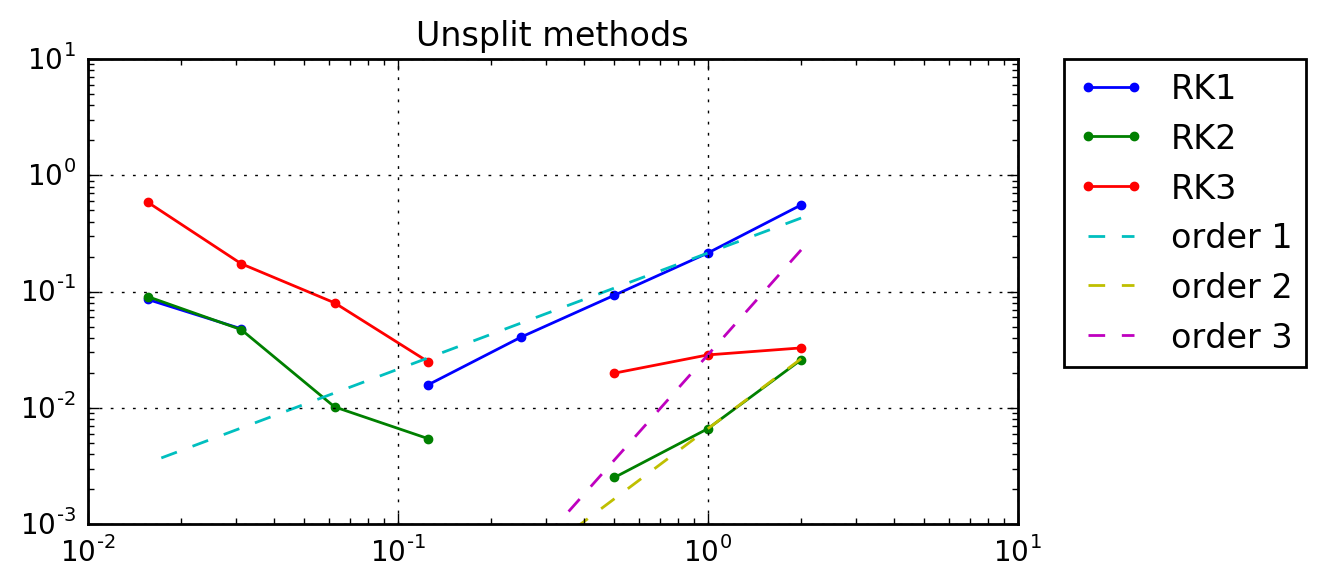

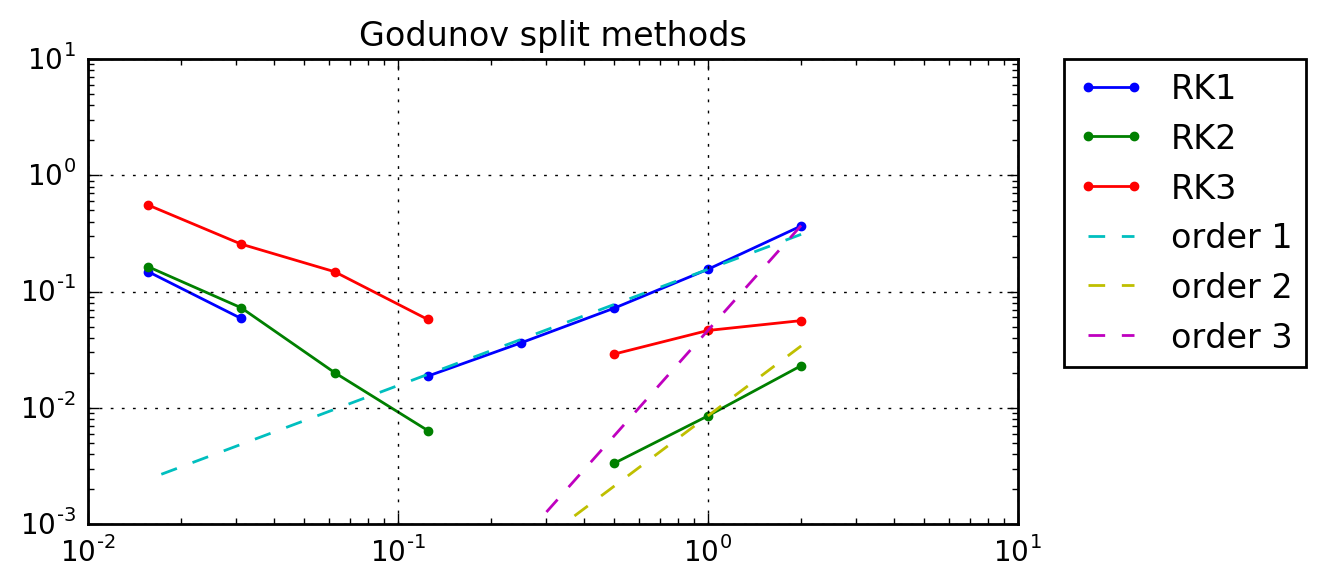

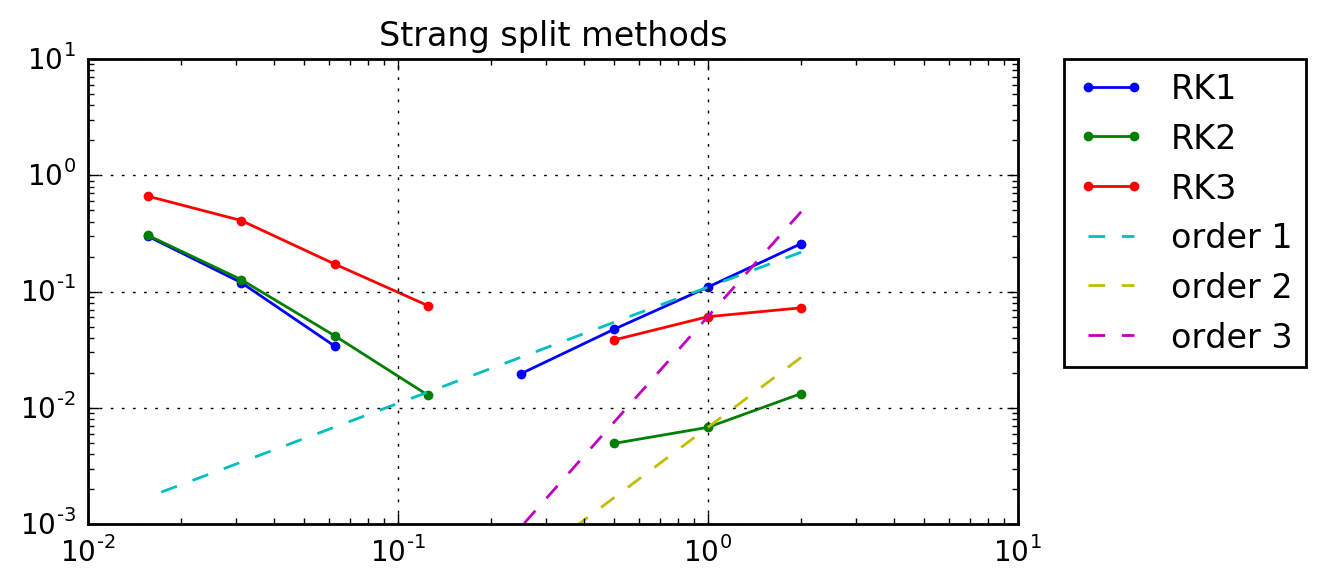

In [279]:
rk1Norms = np.zeros(numDts)
rk2Norms = np.zeros(numDts)
rk3Norms = np.zeros(numDts)
dts = np.zeros(numDts)
titles = ["Unsplit methods", "Godunov split methods", "Strang split methods"]
bestRK1 = [3, 3, 4]
bestRK2 = [5, 5, 5]
bestRK3 = [5, 5, 5]

for p in range(3):
    for i in range(numDts):
        rk1Norms[i] = np.linalg.norm(readResult(p, 1, numDts-bestRK1[p]) - readResult(p, 1, i))
        rk2Norms[i] = np.linalg.norm(readResult(p, 2, numDts-bestRK2[p]) - readResult(p, 2, i))
        rk3Norms[i] = np.linalg.norm(readResult(p, 3, numDts-bestRK3[p]) - readResult(p, 3, i))
        dts[i] =  base_dt/step_size_reductions[i]

    #readResult(split, rk_order, dtNum):
    fig = plt.figure(figsize=(6,3))
    plt.loglog(dts, rk1Norms, '.-', label="RK1")
    plt.loglog(dts, rk2Norms, '.-', label="RK2")
    plt.loglog(dts, rk3Norms, '.-', label="RK3")
    plt.loglog(dts, rk1Norms[1]*dts, "--", label="order 1")
    plt.loglog(dts, rk2Norms[1]*dts**2, "--y", label="order 2")
    plt.loglog(dts[:-2], rk3Norms[1]*dts[:-2]**3, "--m", label="order 3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid()
    plt.ylim(0.001, 10)
    plt.title(titles[p])

Starting (rk_order, step_size_reduction) (1, 1)
Total amount of execive water:  nan
Starting (rk_order, step_size_reduction) (2, 1)
Total amount of execive water:  nan
Starting (rk_order, step_size_reduction) (3, 1)
Total amount of execive water:  nan
Starting (rk_order, step_size_reduction) (1, 2)
Total amount of execive water:  nan
Starting (rk_order, step_size_reduction) (2, 2)
Total amount of execive water:  7.72626
Starting (rk_order, step_size_reduction) (3, 2)
Total amount of execive water:  19.2819
Starting (rk_order, step_size_reduction) (1, 4)
Total amount of execive water:  7.27537
Starting (rk_order, step_size_reduction) (2, 4)
Total amount of execive water:  7.45554
Starting (rk_order, step_size_reduction) (3, 4)
Total amount of execive water:  29.5989
Starting (rk_order, step_size_reduction) (1, 8)
Total amount of execive water:  7.16579
Starting (rk_order, step_size_reduction) (2, 8)
Total amount of execive water:  7.1943
Starting (rk_order, step_size_reduction) (3, 8)
T

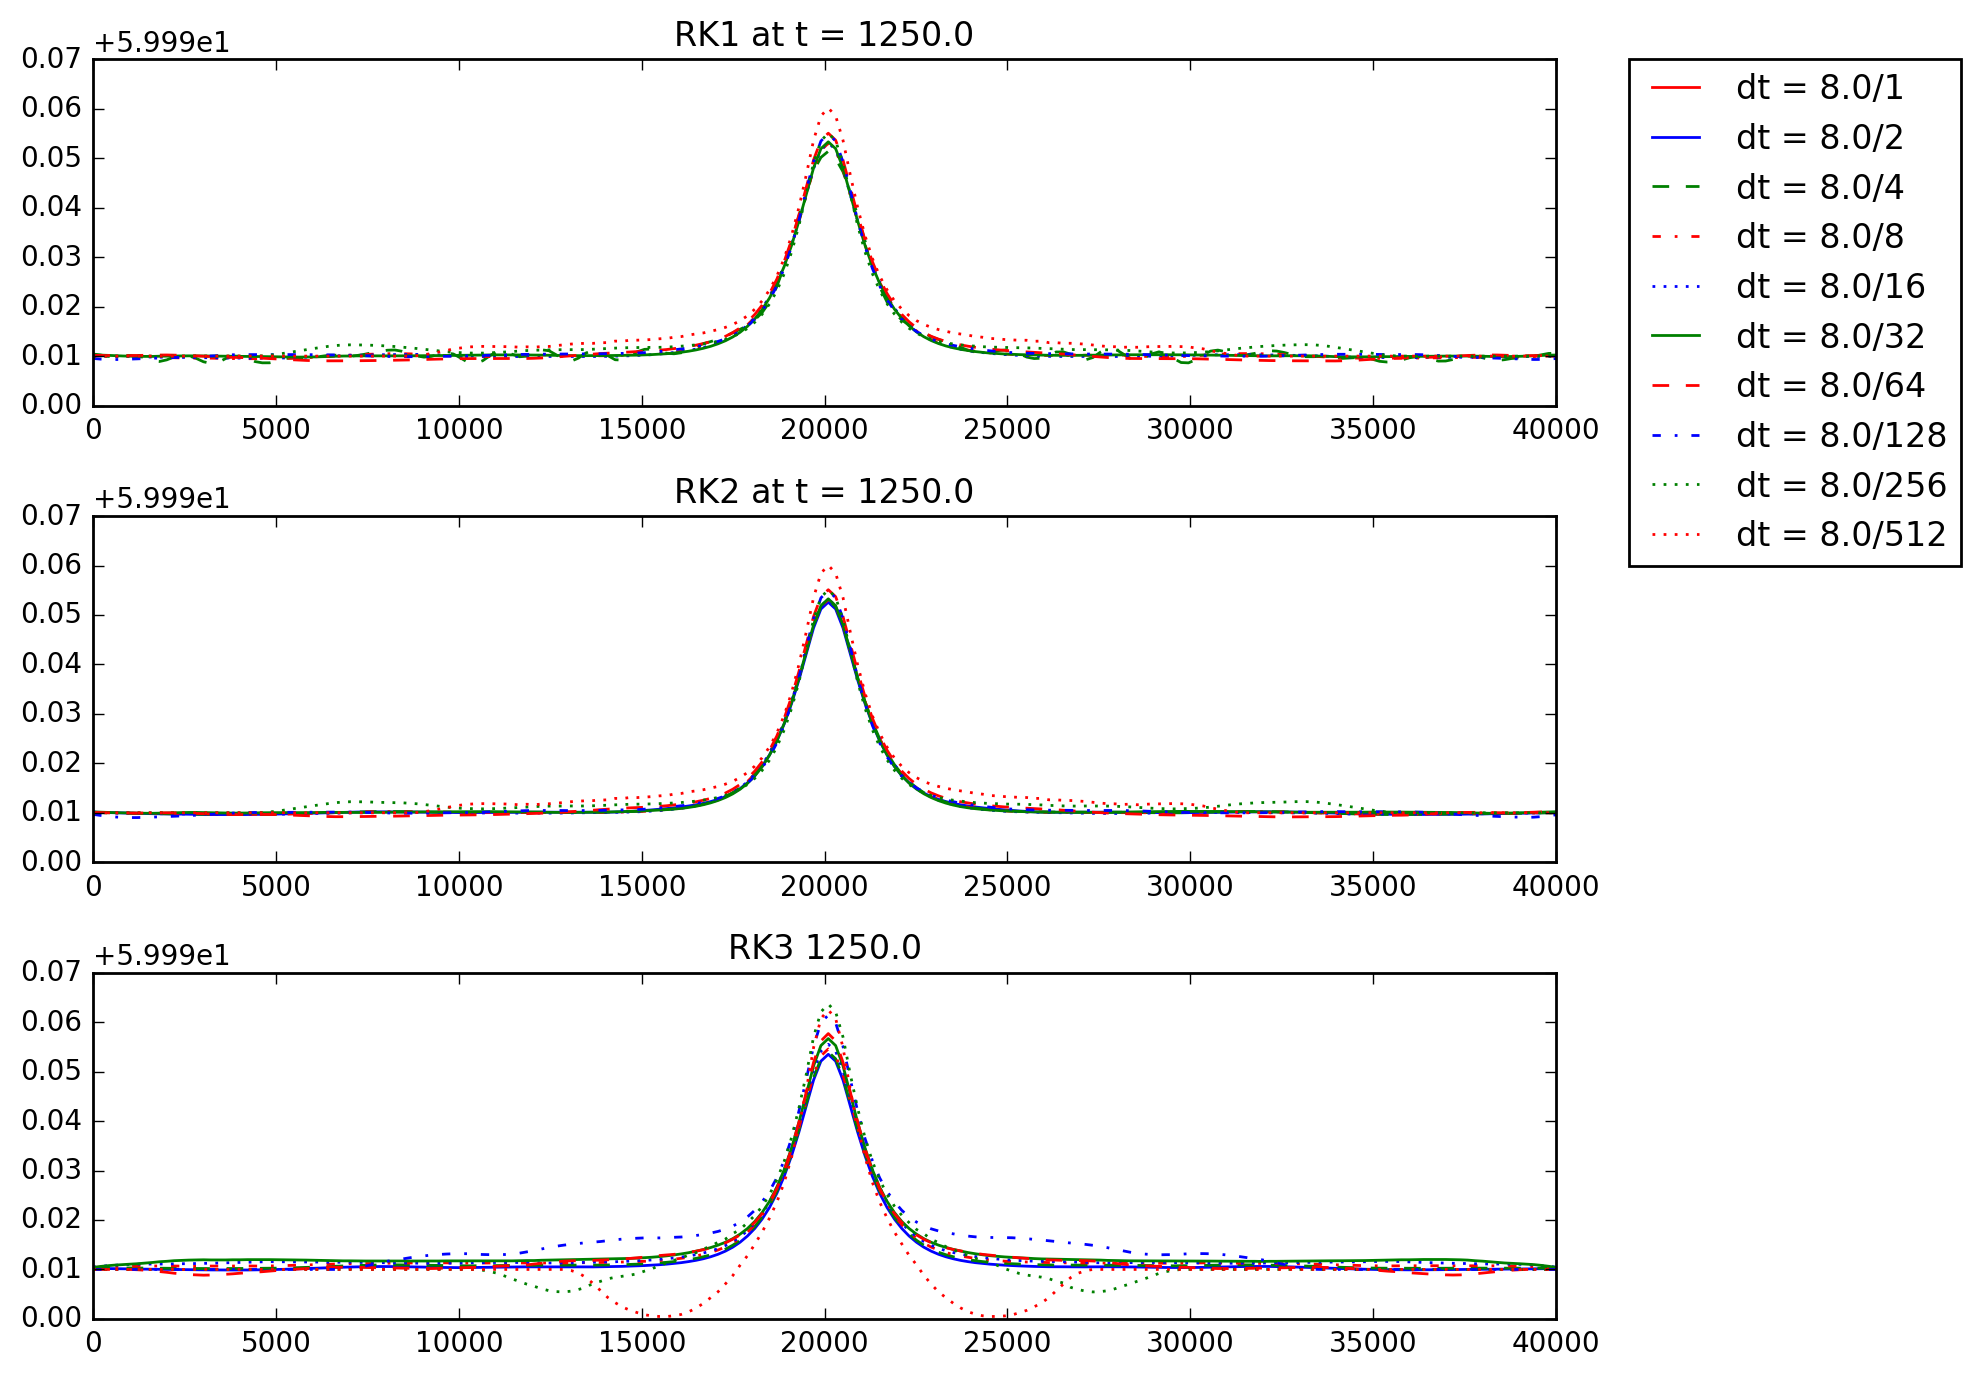

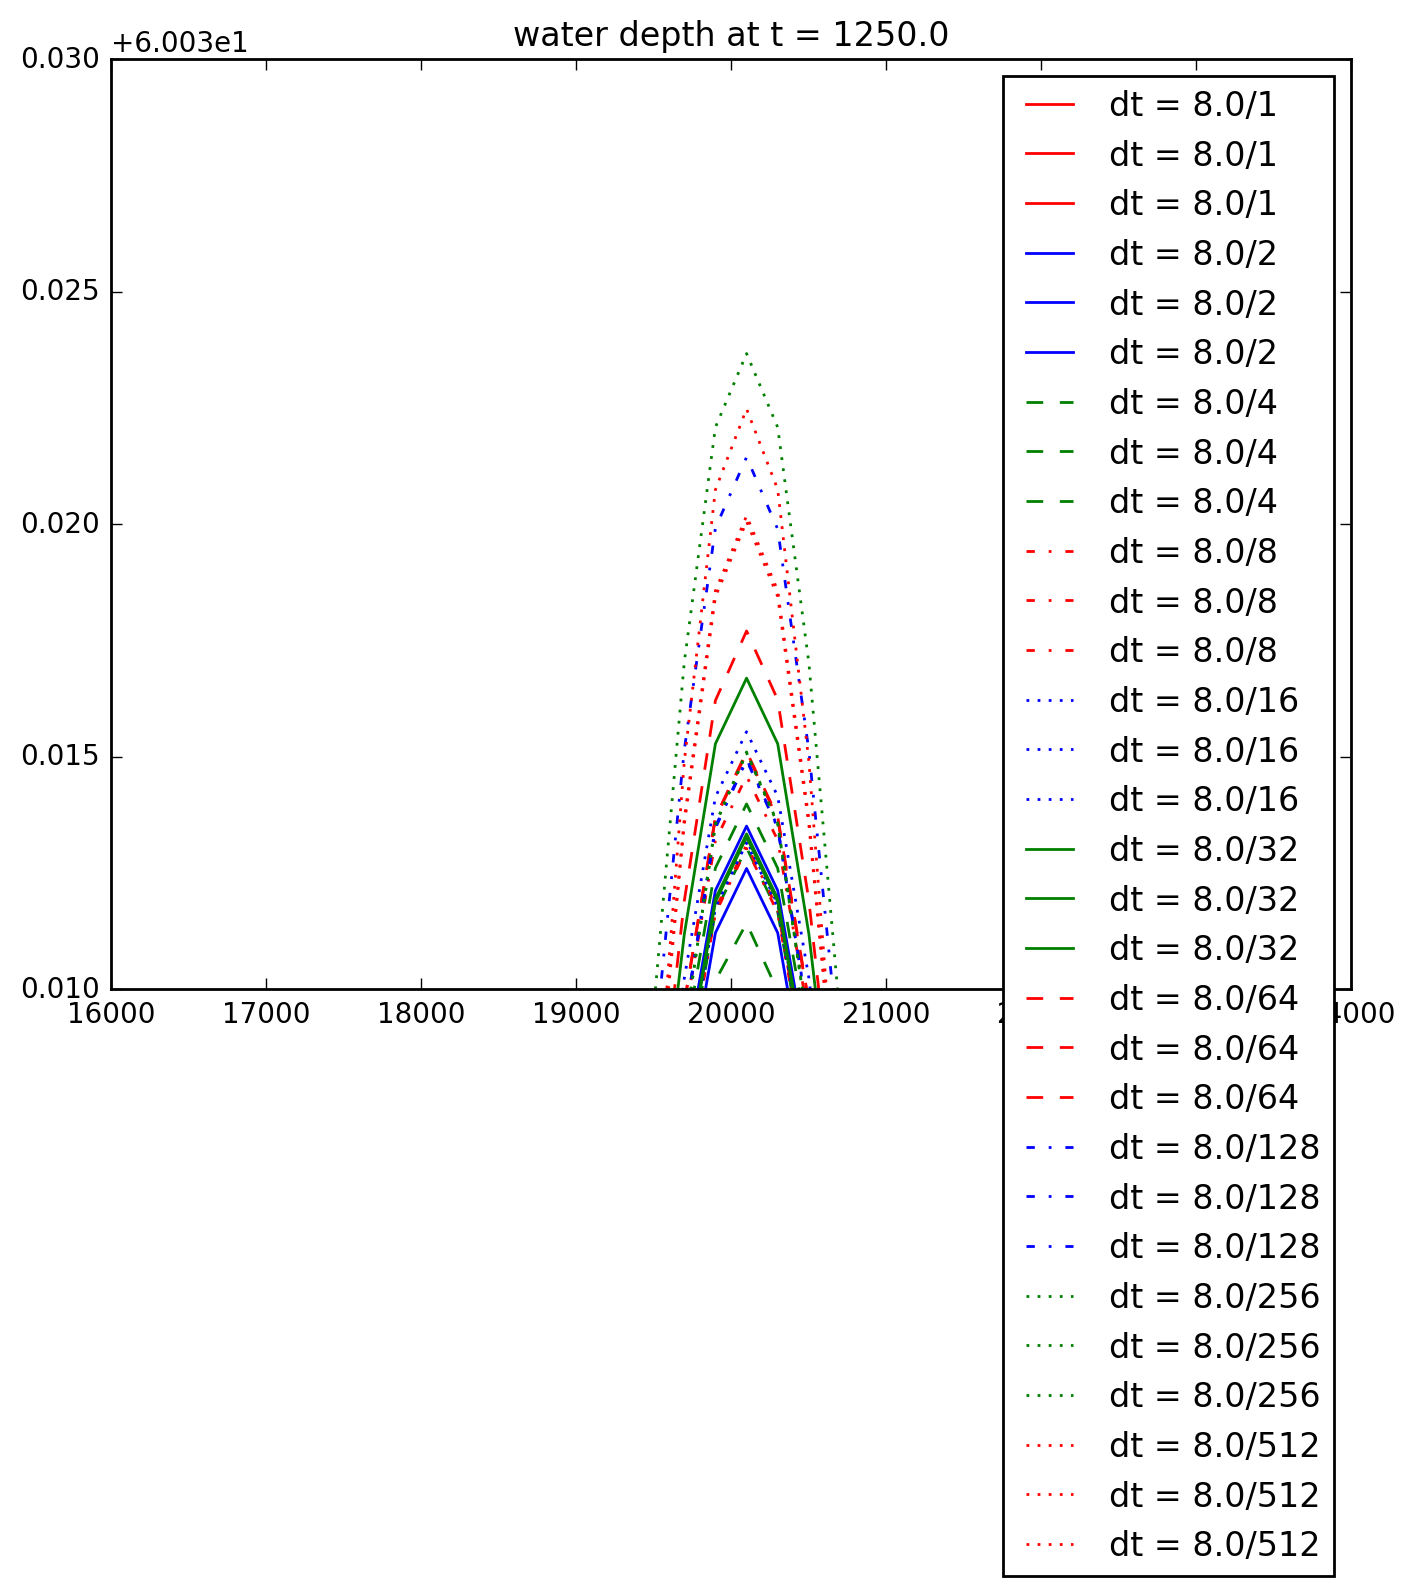

In [151]:
#Clean up old simulator if any:
if 'sim' in globals():
    sim.cleanUp()
    
#Coriolis well balanced reconstruction scheme
nx = 200#+16
ny = 200#+16

dx = 200.0
dy = 200.0

g = 9.81

f = 0.02
r = 0.0

ghosts = np.array([10,10,10,10]) # north, east, south, west
validDomain = np.array([10,10,10,10])
boundaryConditions = Common.BoundaryConditions(3,3,3,3, spongeCells=ghosts)

#ghosts = np.array([2,2,2,2])
#validDomain = np.array([2,2,2,2])
#boundaryConditions = Common.BoundaryConditions(1,1,1,1)


#Calculate radius from center of bump for plotting
x_center = dx*nx/2.0
y_center = dy*ny/2.0
y_coords, x_coords = np.mgrid[0:ny*dy:dy, 0:nx*dx:dx]
x_coords = np.subtract(x_coords, x_center)
y_coords = np.subtract(y_coords, y_center)
radius = np.sqrt(np.multiply(x_coords, x_coords) + np.multiply(y_coords, y_coords))
min_x = np.min(x_coords[:,0]);
min_y = np.min(y_coords[0,:]);

max_x = np.max(x_coords[0,:]);
max_y = np.max(y_coords[:,0]);



dataShape = (ny + ghosts[0]+ghosts[2], 
             nx + ghosts[1]+ghosts[3])

waterHeight = 60
h0 = np.ones(dataShape, dtype=np.float32, order='C') * waterHeight;
u0 = np.zeros(dataShape, dtype=np.float32, order='C');
v0 = np.zeros(dataShape, dtype=np.float32, order='C');

# Bathymetry:
Bi = np.zeros((dataShape[0]+1, dataShape[1]+1), dtype=np.float32, order='C')
#diagonalWallBathymetry(Bi, nx, ny, dx, dy, ghosts, 50)
#makeBathymetryCrater(Bi, nx+1, ny+1, dx, dy, ghosts)

# Staggered u and v
eta0 = np.zeros(dataShape, dtype=np.float32, order='C')
H0 = np.ones(dataShape, dtype=np.float32, order='C') * waterHeight;
u0s = np.zeros((dataShape[0], dataShape[1]+1), dtype=np.float32, order='C');
v0s = np.zeros((dataShape[0]+1, dataShape[1]), dtype=np.float32, order='C');
A = 1.0

addCentralBump(h0, nx, ny, dx, dy, validDomain)
addCentralBump(eta0, nx, ny, dx, dy, validDomain)
nx = nx# - 16
ny = ny# - 16

t1 = 250.0
#t2 = 850.0
t2 = 1250.0
timeString = " at t = " + str(t2)
mainFig = plt.figure(figsize=(8,7))
figh = plt.subplot(3,1,1)
plt.title("RK1"+timeString)
figu = plt.subplot(3,1,2)
plt.title("RK2"+timeString)
figShock = plt.subplot(3,1,3)
plt.title("RK3 " + str(t2))
plt.tight_layout()

zoomFig = plt.figure(figsize=(8, 6))
plt.title("water depth at t = " + str(t2))



x = np.linspace(0.0, nx*dx, num=nx)
step_size_reductions = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
symbols = ["-", "-", "--", "-.", ":", "-", "--", "-.", ":", ":" ]

h1_2_2 = None
h2_2_2 = None
reload(CDKLM16)
reload(CTCS)

for i in range(10):#[2]:#range(4):
    for rk_order in [1, 2, 3]:
        dim_split = 0
        step_size_reduction = step_size_reductions[i]
        symbol = symbols[i]
        
        base_dt = 8.0
        dt = base_dt/step_size_reduction
            
        
        color = 'r'
        if (i%3 == 1):
            color = 'b'
        elif (i%3 == 2):
            color = 'g'
        
        if (rk_order == 5):
            color = 'k'
            print "Starting CTCS with step_size_reduction",  step_size_reduction

            sim = CTCS.CTCS(cl_ctx, \
                       H0, eta0, u0s, v0s, \
                       nx, ny, \
                       dx, dy, dt, \
                       g, f, r, A, \
                       boundary_conditions=boundaryConditions)
            label = "CTCS, dt = 1.0/" + str(step_size_reduction)
        else:
            

            print "Starting (rk_order, step_size_reduction)", (rk_order, step_size_reduction)
            label = "dt = " + str(base_dt) + "/" + str(step_size_reduction)

            #Initialize simulator
            sim = CDKLM16.CDKLM16(cl_ctx, \
                            h0, u0, v0, Bi, \
                            #nx+16, ny+16, \
                            nx, ny, \
                            dx, dy, dt, \
                            g, f, r, \
                            boundary_conditions=boundaryConditions, \
                            rk_order=rk_order, dim_split=dim_split)
        

        t = sim.step(t1)
        h1, u1, v1 = sim.download()
        
        plt.figure(mainFig.number)
        
        t = sim.step(t2)
        h2, u2, v2 = sim.download()

        #h = h2[(ny+20)/2, 10:-10]
        h = h2[10:-10, (nx+20)/2]
        if rk_order == 5:
            h = h + waterHeight
        figh = plt.subplot(3,1,rk_order)
        #if dim_split < 2:
        plt.plot(x, h, color+symbol, label=label)
        
        plt.figure(zoomFig.number)
        #if dim_split == 0 and rk_order > 1:
        plt.plot(x[80:-80], h[80:-80], color+symbol, label=label)
        
        #if rk_order == 2 and dim_split == 0:
        #    h1_2_2 = np.copy(h1[10:-10,10:-10])
        #    h2_2_2 = np.copy(h2[10:-10,10:-10])
            
        print "Total amount of execive water: ", np.sum(np.sum(h2-60))
            
        sim.cleanUp()
        
plt.figure(mainFig.number)

plt.subplot(3,1,1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.figure(zoomFig.number)
plt.ylim(60.04, 60.06)
plt.legend()




## Animation of RK3 using low time step.

In [173]:
reload(CDKLM16)
sim = CDKLM16.CDKLM16(cl_ctx, \
                h0, u0, v0, Bi, \
                nx, ny, \
                dx, dy, 1.0/64, \
                #g, f, r, \
                g, 0.02, r, \
                boundary_conditions=boundaryConditions, \
                rk_order=3, dim_split=0)

#Calculate radius from center of bump for plotting
x_center = dx*nx/2.0
y_center = dy*ny/2.0
y_coords, x_coords = np.mgrid[0:ny*dy:dy, 0:nx*dx:dx]
x_coords = np.subtract(x_coords, x_center)
y_coords = np.subtract(y_coords, y_center)
radius = np.sqrt(np.multiply(x_coords, x_coords) + np.multiply(y_coords, y_coords))


fig = plt.figure()
plotter = PlotHelper.PlotHelper(fig, x_coords, y_coords, radius, 
                                h0[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]] - waterHeight, 
                                u0[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]], 
                                v0[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]])

T = 150
def animate(i):
    if (i>0):
        t = sim.step(10.0)

    else:
        t = 0.0
    h1, u1, v1 = sim.download()

    plotter.plot(h1[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]] - waterHeight, 
                 u1[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]], 
                 v1[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]]);
    fig.suptitle("CDKLM16 Time = " + "{:04.0f}".format(t) + " s", fontsize=18)

    if (i%10 == 0):
        print "{:03.0f}".format(100*i / T) + " % => t=" + str(t) + "\tMax h: " + str(np.max(h1)) + \
        "\tMax u: " + str(np.max(u1)) + \
        "\tMax v: " + str(np.max(v1))
             
anim = animation.FuncAnimation(fig, animate, range(T), interval=100)
plt.close(anim._fig)
anim

000 % => t=0.0	Max h: 61.0	Max u: 0.0	Max v: 0.0
000 % => t=0.0	Max h: 61.0	Max u: 0.0	Max v: 0.0
006 % => t=100.0	Max h: 60.0576	Max u: 1.42159	Max v: 1.4215
013 % => t=200.0	Max h: 60.0549	Max u: 1.32243	Max v: 1.32082
020 % => t=300.0	Max h: 60.0541	Max u: 1.33912	Max v: 1.33737
026 % => t=400.0	Max h: 60.054	Max u: 1.28631	Max v: 1.28584
033 % => t=500.0	Max h: 60.0534	Max u: 1.24393	Max v: 1.24161
040 % => t=600.0	Max h: 60.0533	Max u: 1.2824	Max v: 1.2847
046 % => t=700.0	Max h: 60.0533	Max u: 1.2562	Max v: 1.25577
053 % => t=800.0	Max h: 60.0532	Max u: 1.21069	Max v: 1.20729
060 % => t=900.0	Max h: 60.053	Max u: 1.25408	Max v: 1.2492
066 % => t=1000.0	Max h: 60.0529	Max u: 1.25299	Max v: 1.24648
073 % => t=1100.0	Max h: 60.0527	Max u: 1.19049	Max v: 1.19096
080 % => t=1200.0	Max h: 60.0526	Max u: 1.2308	Max v: 1.2262
086 % => t=1300.0	Max h: 60.0526	Max u: 1.25534	Max v: 1.25014
093 % => t=1400.0	Max h: 60.0526	Max u: 1.18673	Max v: 1.18585


In [149]:
print validDomain


[10 10 10 10]


# No case, just playing around

In [ ]:

def erf(x):
    # save the sign of x
    sign = 1 if x >= 0 else -1
    x = abs(x)

    # constants
    a1 =  0.254829592
    a2 = -0.284496736
    a3 =  1.421413741
    a4 = -1.453152027
    a5 =  1.061405429
    p  =  0.3275911

    # A&S formula 7.1.26
    t = 1.0/(1.0 + p*x)
    y = 1.0 - (((((a5*t + a4)*t) + a3)*t + a2)*t + a1)*t*np.exp(-x*x)
    return sign*y # erf(-x) = -erf(x)
asquare = g*waterHeight/(f*f)
a = np.sqrt(asquare)
exact = np.zeros_like(x)
h0exact = h0[(ny+20)/2, 10:-10]
for i in range(len(x)):
    x1 = (x[i] - (nx*dx/2))#/20000
    erf1 = erf(1/(2*a) + x1)
    erf2 = erf(1/(2*a) - x1)
    
    exact[i] =  (np.sqrt(np.pi)/(4*a)) * np.exp(1.0/(4*asquare)) * \
                ( np.exp(x1/a)*erf1 + np.exp(-x1/a)*erf2 )#*(h0exact[i]-waterHeight)
    #exact[i] = erf1 + erf2
                

exactFig = plt.figure(figsize=(7,3))
plt.plot(x, exact)
#plt.ylim(-1.5, 1.5)



In [ ]:
#Clean up old simulator if any:
if 'sim' in globals():
    sim.cleanUp()
    
#Coriolis well balanced reconstruction scheme
nx = 200
ny = 200

dx = 200.0
dy = 200.0

dt = 0.95/5.0
g = 9.81

f = 0.02
r = 0.0

# WIND
#wind = Common.WindStressParams(type=0, tau0=3.0, rho=1025, alpha=1.0/(100*dx))
wind = Common.WindStressParams(type=99)

bcSettings = 1
ghosts = np.array([2,2,2,2]) # north, east, south, west
validDomain = np.array([2,2,2,2])
if (bcSettings == 1):
    boundaryConditions = Common.BoundaryConditions()
elif (bcSettings == 2):
    boundaryConditions = Common.BoundaryConditions(2,2,2,2)
elif bcSettings == 3:
    # Periodic NS
    boundaryConditions = Common.BoundaryConditions(2,1,2,1)
elif bcSettings == 4:
    # Periodic EW
    boundaryConditions = Common.BoundaryConditions(1,2,1,2)
else:
    # Open boundary
    ghosts = np.array([10,10,10,10]) # north, east, south, west
    validDomain = np.array([10,10,10,10])
    boundaryConditions = Common.BoundaryConditions(3,3,3,3, spongeCells=ghosts)
    
dataShape = (ny + ghosts[0]+ghosts[2], 
             nx + ghosts[1]+ghosts[3])


waterHeight = 60
h0 = np.ones(dataShape, dtype=np.float32, order='C') * waterHeight;
u0 = np.zeros(dataShape, dtype=np.float32, order='C');
v0 = np.zeros(dataShape, dtype=np.float32, order='C');

# Bathymetry:
Bi = np.zeros((dataShape[0]+1, dataShape[1]+1), dtype=np.float32, order='C')
#diagonalWallBathymetry(Bi, nx, ny, dx, dy, ghosts, 50)
#straightWallBathymetry(Bi, nx, ny, dx, dy, ghosts, 50)
#makeBathymetryCrater(Bi, nx+1, ny+1, dx, dy, ghosts)
#linearBathymetryX(Bi, nx, ny, dx, dy, ghosts, 5, 50)
#linearBathymetryY(Bi, nx, ny, dx, dy, ghosts, 5, 50)

addCentralBump(h0, nx, ny, dx, dy, validDomain)
#addStraightDam(h0, nx, ny, dx, dy, ghosts, 0.1)
#addDiagonalDam(h0, nx, ny, dx, dy, ghosts, 0.1)


#Initialize simulator
reload(CDKLM16)
sim = CDKLM16.CDKLM16(cl_ctx, \
                h0, u0, v0, \
                Bi, \
                nx, ny, \
                dx, dy, dt, \
                g, f, r, \
                wind_stress=wind, \
                boundary_conditions=boundaryConditions, \
                reportGeostrophicEquilibrium=False, \
                rk_order=4, dim_split=0)

#Calculate radius from center of bump for plotting
x_center = dx*nx/2.0
y_center = dy*ny/2.0
y_coords, x_coords = np.mgrid[0:ny*dy:dy, 0:nx*dx:dx]
x_coords = np.subtract(x_coords, x_center)
y_coords = np.subtract(y_coords, y_center)
radius = np.sqrt(np.multiply(x_coords, x_coords) + np.multiply(y_coords, y_coords))


fig = plt.figure()
plotter = PlotHelper.PlotHelper(fig, x_coords, y_coords, radius, 
                                h0[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]] - waterHeight, 
                                u0[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]], 
                                v0[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]])

T = 50
def animate(i):
    if (i>0):
        t = sim.step(10.0)

    else:
        t = 0.0
    h1, u1, v1 = sim.download()

    brighten = 1
    
    plotter.plot(h1[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]] - waterHeight, 
                 brighten*u1[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]], 
                 brighten*v1[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]]);
    fig.suptitle("CDKLM16 Time = " + "{:04.0f}".format(t) + " s", fontsize=18)

    if (i%10 == 0):
        print "{:03.0f}".format(100*i / T) + " % => t=" + str(t) + "\tMax h: " + str(np.max(h1)) + \
        "\tMax u: " + str(np.max(u1)) + \
        "\tMax v: " + str(np.max(v1))
        
        fig.savefig(imgdir + "/{:010.0f}_cdklm16.png".format(t))
             
anim = animation.FuncAnimation(fig, animate, range(T), interval=100)
plt.close(anim._fig)
anim

In [8]:
sim.cleanUp()

In [ ]:
h3, hu3, hv3 = sim.download()
print("Initial water volume: ", sum(sum(h0)))
print("After simulation:     ", sum(sum(h3)))
print(imgdir)
print("min-max h:           ", np.min(h3), np.max(h3))
print("min-max hu:           ", np.min(hu3), np.max(hu3))
print("min-max hv:           ", np.min(hv3), np.max(hv3))